# Présentation du projet : 

## Contexte 

Stack Overflow est un site célèbre de questions-réponses liées au développement informatique. Pour poser une question sur ce site, il faut entrer plusieurs tags de manière à retrouver facilement la question par la suite. Pour les utilisateurs expérimentés, cela ne pose pas de problème, mais pour les nouveaux utilisateurs, il serait judicieux de suggérer quelques tags relatifs à la question posée.

Amateur de Stack Overflow, qui vous a souvent sauvé la mise, vous décidez d'aider la communauté en retour. Pour cela, vous développez un système de suggestion de tag pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.


## Données 



Stack Overflow propose un outil d’export de données - "stackexchange explorer", qui recense un grand nombre de données authentiques de la plateforme d’entraide. 

## Mission
### Contraintes


* Mettre en œuvre une approche non supervisée.
* Utiliser une approche supervisée ou non pour extraire des tags à partir des résultats précédents.
* Comparer ses résultats à une approche purement supervisée, après avoir appliqué des méthodes d’extraction de features spécifiques des données textuelles.
* Mettre en place une méthode d’évaluation propre, avec une séparation du jeu de données pour l’évaluation.
* Pour suivre les modifications du code final à déployer, utiliser un logiciel de gestion de versions, par exemple Git.

### Livrable attendu ici
Un notebook d’exploration comprenant une analyse univariée, une analyse multivariée, une réduction dimensionnelle et les différentes questions de recherches associées (non cleané, pour comprendre votre démarche).

# Ressources : 

## Les données et leur description :

Site d'extraction des données :

Traitement de texte (NLP) : 
* Le cours OC sur le traitement de text : https://openclassrooms.com/fr/courses/4470541-analysez-vos-donnees-textuelles/
* Les ressources compémentaires proposées dans le projet :
    * La doc sklearn : https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
    * Article - overview extraction de mot-clé : https://jios.foi.hr/index.php/jios/article/view/938/724
    * Tuto Kaggle Word2Vec : https://www.kaggle.com/c/word2vec-nlp-tutorial#part-1-for-beginners-bag-of-words
    * Livre NLTK (Natural Language Toolkit) : http://www.nltk.org/book/
    * Slide de présentation séminaire sur "Topic Models" Thibaut THONET : https://www.irit.fr/IRIS-site/images/seminairs/Thonet2016.pdf
    
## Le suivi git :
Ce projet, comme les autres projets de la formation, est suivi dans le répertoire github https://github.com/ClaireGayral/formation_openclassroom/tree/master/P5_gayral_claire

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import pickle


data_path = "/home/clairegayral/Documents/openclassroom/data/P5/"
res_path = "/home/clairegayral/Documents/openclassroom/res/P5/"

## my .py : 
from script01_duplicates import *
from script02_missing_values_treatment import *
from script03_univariate_analysis import *
from script04_multivariate_analysis import *
from script05_CV_regression import *
from script06_reduce_dim import *

## extract list of text :
from bs4 import BeautifulSoup
import re
# from sklearn.feature_extraction.s import s# import ENGLISH_STOP_WORDS

# from sklearn import model_selection 
# from sklearn import preprocessing
# from sklearn import neighbors
# from sklearn import linear_model

# from sklearn.impute import KNNImputer
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
# from sklearn.cluster import AgglomerativeClustering
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import fbeta_score
# from sklearn.metrics import make_scorer
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import fowlkes_mallows_score
# from sklearn.metrics.pairwise import pairwise_kernels


# from sklearn.preprocessing import OneHotEncoder
# from sklearn.linear_model import LogisticRegression

# from scipy.cluster.hierarchy import cut_tree
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram


from bs4 import BeautifulSoup
import nltk
from collections import defaultdict
from nltk.stem.snowball import EnglishStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.utils import tokenize
from gensim import corpora
from gensim import models
from gensim.models import FastText

## Plan du notebook :


Pour faciliter la lecture, il est possible de revenir à ce sommaire, en cliquant sur [back to menu](#menu) chaque fois qu'il apparaît. A partir de ce menu, il est possible de naviguer entre les parties en cliquant sur leur titre.


<a id ="menu"></a>
1. [Importer les données](#section1)
    1. [Preprocessing sur les tags](#section1.1)
    2. [Preprocessing sur les titres/corpus](#section1.2)
    
2. [Création de la variable de sortie - les tags](#section2)
    1. [Projection des tags](#section2.1)
    2. [Regroupement des tags](#section2.2)
    3. [Construction d'une variable retour y](#section2.3)
    
3. [Traitements sur le text](#section3)
    1. [Preprocessing sur les tokens](#section1.2)
        2. [Tokenization](#section3.1.1)
        3. [Stopwords](#section3.1.2)
        4. [Lemmatization](#section3.1.3)   
    2. [Représentation des mots](#section3.2)
          1. [Bag of Words](#section3.2.1)
          2. [tf-idf](#section3.2.2)
          3. [Word to vect](#section3.2.3)       
          4. [Représentation en nuage de mots](#section3.2.4)
<!--     3. [Réduction de dimension](#section3.3) -->


<a id ="section1"></a>
<!-- <a id ="section1.1"></a> -->

[back to menu](#menu)
# 1. Importer les données :
##  Première lecture
J'ai téléchargé un set de données depuis le site https://data.stackexchange.com/stackoverflow/query/new, en [lançant la commande](https://data.stackexchange.com/stackoverflow/query/edit/1533520) "SELECT Id FROM posts WHERE  Id > 100001" 

In [54]:
df1 = pd.read_csv(data_path + "QueryResults_Id_0_50000.csv")
df1 = df1.set_index("Id")#.iloc[:1000,:]
print(df1.shape)
df1.head(3)

(50000, 22)


,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,...,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,ContentLicense
Id,,,,,,,,,,,,,,,,,,,,,
4,1,7.0,NaN,2008-07-31 21:42:52,NaN,727,58688.0,<p>I want to use a <code>Track-Bar</code> to c...,8.0,NaN,...,2021-02-26 03:31:15,2021-02-26 03:31:15,How to convert a Decimal to a Double in C#?,<c#><floating-point><type-conversion><double><...,14.0,5,55.0,NaN,2012-10-31 16:42:47,CC BY-SA 4.0
6,1,31.0,NaN,2008-07-31 22:08:08,NaN,306,21663.0,<p>I have an absolutely positioned <code>div</...,9.0,NaN,...,2021-01-29 18:46:45,2021-01-29 18:46:45,Why did the width collapse in the percentage w...,<html><css><internet-explorer-7>,7.0,0,12.0,NaN,NaN,CC BY-SA 4.0
7,2,NaN,4.0,2008-07-31 22:17:57,NaN,482,NaN,<p>An explicit cast to <code>double</code> lik...,9.0,NaN,...,2019-10-21 14:03:54,2019-10-21 14:03:54,NaN,NaN,NaN,0,NaN,NaN,NaN,CC BY-SA 4.0


Visiblement seuls trois colonnes vont avoir un intérêt pour cette étude. Il s'agit des colonnes "Title" et "Body" comme ensemble d'entrée, et "Tags" comme sortie. Comme je vais avoir besoin des tags, je relance ma requête sql pour y ajouter le filtre "les tags existent", c'est-à-dire SELECT Id, Title, Tags, Body FROM posts WHERE Id < 100000 AND Tags <> '' 

In [55]:
df1 = pd.read_csv(data_path + "QueryResults_Id_tags_0_100000.csv")
df1 = df1.set_index("Id")#.iloc[:1000,:]
print(df1.shape)
df1.head(3)

(11095, 3)


,Title,Tags,Body
Id,,,
4,How to convert a Decimal to a Double in C#?,<c#><floating-point><type-conversion><double><...,<p>I want to use a <code>Track-Bar</code> to c...
6,Why did the width collapse in the percentage w...,<html><css><internet-explorer-7>,<p>I have an absolutely positioned <code>div</...
9,How do I calculate someone's age based on a Da...,<c#><.net><datetime>,<p>Given a <code>DateTime</code> representing ...


In [56]:
title = df1["Title"]
body = df1["Body"]
tags = df1["Tags"]

In [80]:
body.iloc[0]

'<p>I want to use a <code>Track-Bar</code> to change a <code>Form</code>\'s opacity.</p>\n<p>This is my code:</p>\n<pre class="lang-cs prettyprint-override"><code>decimal trans = trackBar1.Value / 5000;\nthis.Opacity = trans;\n</code></pre>\n<p>When I build the application, it gives the following error:</p>\n<blockquote>\n<pre class="lang-none prettyprint-override"><code>Cannot implicitly convert type decimal to double\n</code></pre>\n</blockquote>\n<p>I have tried using <code>trans</code> and <code>double</code>, but then the <code>Control</code> doesn\'t work. This code worked fine in a past VB.NET project.</p>\n'

Il sera peut-être judicieux d'utiliser d'autres colonnes correspondant à la réponse de la communauté pour voir si le post a été tagué correctement. Il s'agirait de faire un  filtre sur les données d'apprentissage, puisqu'on ne veut pas apprendre des questions mal taguées. 

Pour le moment je vais me satisfaire de cet ensemble d'apprentissage. Comme c'est la première fois que je fais du NLP, je vais d'abord regarder comment faire un prétraitement sur les titres (parce que plus petit ensemble) 

Une requête plus intelligente sera alors : 
SELECT Id, Title, Tags, Body  FROM posts WHERE  Id > 100

Avant d'avancer plus loin, il est nécessaire de remplacer les abbréviation et différentes versions des langages de programmation par un mot homogène. J'ai ainsi utilisé un dictionnaire suivant pour remplacer. Ce dictionnaire propose une correspondance entre les abréviations et le nom uniformisé. Par exemple, pour C++, il a les clés :

In [57]:
from dict_lang_modif import * 
{k: abr for k,abr in lang_dict.items() if abr == "cplusplus"}

{'c++': 'cplusplus',
 'C++': 'cplusplus',
 'c++14': 'cplusplus',
 'C++14': 'cplusplus',
 'c++17': 'cplusplus',
 'C++17': 'cplusplus',
 'c++98': 'cplusplus',
 'C++98': 'cplusplus',
 'c++11': 'cplusplus',
 'C++11': 'cplusplus',
 'c++20': 'cplusplus',
 'clang++': 'cplusplus',
 'libstdc++': 'cplusplus',
 'libs++': 'cplusplus',
 'c++-cli': 'cplusplus',
 'c++-faq': 'cplusplus',
 'c++-tr2': 'cplusplus',
 'c++builder': 'cplusplus'}

Et pour chaque étape suivante, je remplacerai les clé de ce dictionnaire par les valeurs. 

<a id ="section1.1"></a>

[back to menu](#menu)

## 1.A Preprocessing sur les tags 

Dans le projet, il est demandé de traiter le problème de deux manières : 
* Non supervisé : je pense faire appel au [module tags de la bibliothèque python nltk](http://www.nltk.org/api/nltk.tag.html#module-nltk.tag). Il pourra être pertinent de comparer cette approche avec les tags attribué par les internautes, ce pourquoi le preprocess des tags me paraissait pertinent à faire en premier lieu.
* Supervisé : pour cela, j'aurai besoin d'avoir extrait les tags des posts de slackoverflow pour les apprendre/tester les modèles. C'est ce que je compte faire dans cette partie.

Les tags sont dans un format entre balises, je vais les mettre dans une pd.DataFrame avec en colonne les différents tags et en ligne les posts. La matrice sera rempli du nombre d'occurence des tags. Elle sera donc sparse. 

In [58]:
tags = tags[~tags.isna()]
## test separation des tags entre balise
import re
print("test sur un post :", re.findall(r"\<([^>]*)",tags.iloc[0]))

## creation de la pd.DataFrame
df_tags = {}
for idx in tags.index : #[:1000] : 
    list_tags = re.findall(r"\<([^>]*)",tags.loc[idx])
    df_tags[idx] = pd.get_dummies(list_tags).sum()
df_tags = pd.DataFrame(df_tags).transpose()
df_tags = df_tags.fillna(0)
df_tags.head()

test sur un post : ['c#', 'floating-point', 'type-conversion', 'double', 'decimal']


,.htaccess,.htpasswd,.net,.net-1.0,.net-1.1,.net-2.0,.net-3.0,.net-3.5,.net-assembly,.net-attributes,...,zeroconf,zfs,zip,zipcode,zipinputstream,zipoutputstream,zlib,zos,zsh,zxspectrum
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Je remplace les abréviations et versions de langage. Je complète un peu le dictionnaire ici avec par exemple : 

In [59]:
{k: abr for k,abr in lang_dict.items() if abr == "dotnet"}

{'.net': 'dotnet',
 '.net-1.0': 'dotnet',
 '.net-1.1': 'dotnet',
 '.net-2.0': 'dotnet',
 '.net-3.0': 'dotnet',
 '.net-3.5': 'dotnet',
 '.net-4.0': 'dotnet',
 '.net-assembly': 'dotnet',
 '.net-attributes': 'dotnet',
 '.net-client-profile': 'dotnet',
 '.net-framework-version': 'dotnet'}

In [60]:
[k for k,abr in lang_dict.items() if abr == "csharp"]

['c#', 'C#', 'c#-2.0', 'c#-3.0', 'c#-4.0']

In [61]:
df_tags.columns[["c#" in n for n in df_tags.columns]]

Index(['c#', 'c#-2.0', 'c#-3.0', 'vb.net-to-c#'], dtype='object')

In [62]:
# # Remplace mapping values and sum columns :
# df_new = df_tags.groupby(df_tags.columns.map(lang_dict), axis=1).sum()
# df_new[df_new >1] = 1 # if multiple values in dict, reset to (dummies)
# df_new = pd.concat((df_tags,df_new), axis= 1)
# df_tags = df_new.drop(df_new.columns.intersection(lang_dict.keys()), axis=1)
# df_tags.head()

# df_tags.to_csv(res_path + "tags_preprocessed_table.csv")

In [63]:
lang_dict
reverse_lang_dict = {}
for k,v in lang_dict.items():
    if v in reverse_lang_dict.keys():
        reverse_lang_dict[v].append(k)
    else :
        reverse_lang_dict[v] = [k]
## add key to dict values :        
for k in lang_dict.keys():
    if k not in lang_dict[k] :
        reverse_lang_dict[v].append(k)
list_lang = list(reverse_lang_dict.keys())
map_lang = {"lang_"+str(i) : list_lang[i] for i in range(len(list_lang))}
reverse_map_lang = {v:k for k,v in map_lang.items()}

df_new = df_tags.copy()
# Remplace mapping values and sum columns :
for new, list_old in reverse_lang_dict.items():
    print(new)
    tmp_name = reverse_map_lang[new]
    df_new.loc[:,tmp_name] = df_tags.loc[:, df_tags.columns.intersection(list_old)].sum(axis = 1)
    removed_col = df_new.columns.intersection(list_old)
    df_new = df_new.drop(removed_col, axis = 1)
df_new[df_new > 1] = 1
df_tags = df_new.rename(map_lang, axis=1)

csharp
goLang
VisualBasic
d3js
gplusplus
cplusplus
clang
Qt_framework
vuejs
rLang
dotnet
input_output
javascript
VisualStudio
sql


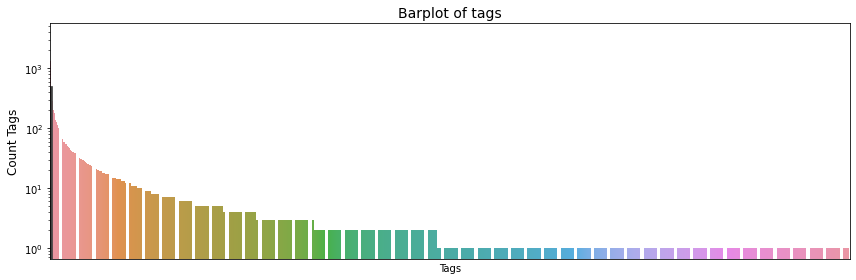

In [64]:
# df_tags.plot(kind="bar")
plt.rcParams["figure.figsize"] = (12,4)
tmp = df_tags.sum(axis=0).sort_values(ascending=False)
sns.barplot(y=tmp.values,x=tmp.index)
plt.xlabel("Tags", fontsize=10)
# plt.xticks(rotation=90, fontsize=6) # print xticks
plt.xticks([]) # remove xticks
plt.ylabel("Count Tags", fontsize=12)
plt.yscale("log")
plt.title("Barplot of tags", fontsize=14)
plt.tight_layout()
plt.savefig(res_path+"figures/"+"barplot_tags.jpg")
plt.show()

<a id ="section1.2"></a>

[back to menu](#menu)

## 1.2 Preprocessing sur les titres/corpus

J'ai choisi de commencer par suivre les étapes [du cours d'OpenClassRoom sur les traitement textes](https://openclassrooms.com/fr/courses/4470541-analysez-vos-donnees-textuelles). 

### Récupération et exploration du corpus de texte 
Je ne suis pas concernée par la partie "scrap" puisque j'ai déjà mon texte. 

Néansmoins, il y a deux points nécessaires à traiter a ce stade : 
1. Il faut sortir de la syntaxe html pour avoir un format text. Les balises de code semblent importante à garder, ne serait-ce que parce que certaines contiennent le langage de programmation.
2. je vais essayer d'insérer les titles dans les corpus, car il y a {{title.isna().sum()/title.shape[0]*100}}$\%$ de valeurs maquantes pour les titles. 

###  De HTML à text

In [338]:
body.iloc[0]

'<p>I want to use a <code>Track-Bar</code> to change a <code>Form</code>\'s opacity.</p>\n<p>This is my code:</p>\n<pre class="lang-cs prettyprint-override"><code>decimal trans = trackBar1.Value / 5000;\nthis.Opacity = trans;\n</code></pre>\n<p>When I build the application, it gives the following error:</p>\n<blockquote>\n<pre class="lang-none prettyprint-override"><code>Cannot implicitly convert type decimal to double\n</code></pre>\n</blockquote>\n<p>I have tried using <code>trans</code> and <code>double</code>, but then the <code>Control</code> doesn\'t work. This code worked fine in a past VB.NET project.</p>\n'

In [339]:
def extract_text_btw_html(html):
#     html = title_+body_
    soup = BeautifulSoup(html)
    for script in soup(["script", "style"]):
        script.decompose()
    return(list(soup.stripped_strings))

# Use regular expressions to do a find-and-replace
def letter_only(my_text):
    return(re.sub("[^a-zA-Z]",   # The pattern to search for
                      " ",       # The pattern to replace it with
                      my_text ))  # The text to search

def from_list_of_sentences_to_tokens(list_text):
    tokens=[]
    for text in list_text : #[:20] :
        ## soit le code fait mqin depuis tuto kaggle
        text = letter_only(text.lower())
        text_token = nltk.word_tokenize(text)
#         ## soit tout fonction tout pret de nltk
#         text_token = tokenizer.tokenize(text.lower())
        
        tokens = tokens + text_token
    return(tokens)

In [340]:
# nltk.download('punkt')
posts = {}
posts_tokens = {}
for idx in body.index[3:4] : 
    body_ = body.loc[idx]
    title_ = title.loc[idx]
    if pd.isna(title_) :
        text = str(body_)
    else :
        text = title_ + body_
    list_text = extract_text_btw_html(text)
    posts[idx]=  ' '.join(list_text)
    tokens = from_list_of_sentences_to_tokens(list_text)
    posts_tokens[idx] = tokens

Comme pour les tags, il faut homogénéiser les mots importants qui existent sous plusieurs versions, en particulier pour les nombres de langage de programmation :

In [341]:
def replace_with_dict_val(my_list, my_dict) :
    for i in range(len(my_list)) :
        t = my_list[i]
        if t in lang_dict.keys():
            t = lang_dict[t]
    return(my_list)

In [342]:
# nltk.download('punkt')
posts = {}
posts_tokens = {}
for idx in body.index : 
    body_ = body.loc[idx]
    title_ = title.loc[idx]
    if pd.isna(title_) :
        text = str(body_)
    else :
        text = title_ + body_
    list_text = extract_text_btw_html(text)
    posts[idx]=  ' '.join(list_text)
    tokens = from_list_of_sentences_to_tokens(list_text)
    tokens = replace_with_dict_val(tokens, lang_dict)
    posts_tokens[idx] = tokens

Et j'enregistre ces tokens pour la suite : 

In [343]:
# with open(res_path+"tokens"+".pkl", "wb") as f :
#     pickle.dump(posts_tokens, f, pickle.HIGHEST_PROTOCOL)

<a id ="section2"></a>
[back to menu](#menu)

# 2. Création de la variable de sortie - les tags
Pour cette partie, j'ai appris la structure sur un autre ensemble de tags que celui de l'apprentissage (mêmes tags, dans d'autres posts). Comme il y avait énormément de tags seuls dans mon ensemble initial, j'en ai extrait un plus gros, mais en ne gardant que les tags, avec la commande SELECT Id, Title, Tags, Body  FROM posts WHERE  Id > 10000 AND Tags <> '' 

In [11]:
tags2 = pd.read_csv(data_path + "QueryResults_Id_tags_50000_100000.csv")
tags2 = tags2["Tags"].dropna()

## creation de la pd.DataFrame
df_tags2 = {}
for idx in tags2.index : #[:1000] : 
    list_tags2 = re.findall(r"\<([^>]*)",tags2.loc[idx])
    df_tags2[idx] = pd.get_dummies(list_tags2).sum()
df_tags2 = pd.DataFrame(df_tags2).transpose()
df_tags2 = df_tags2.fillna(0)

## remove empty lines : 
df_tags2 = df_tags2.drop(df_tags2.loc[df_tags2.sum(axis=1) == 0,:].index, axis=0)
df_tags2.head()

,.emf,.htaccess,.net,.net-1.1,.net-2.0,.net-3.0,.net-3.5,.net-4.0,.net-assembly,.net-attributes,...,zip,zipinputstream,zipoutputstream,zk,zlib,zooming,zsh,zsi,zune,zxspectrum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


J'homogéneise aussi dans cette table les langages de programmation :

In [13]:
lang_dict
reverse_lang_dict = {}
for k,v in lang_dict.items():
    if v in reverse_lang_dict.keys():
        reverse_lang_dict[v].append(k)
    else :
        reverse_lang_dict[v] = [k]
## add key to dict values :        
for k in lang_dict.keys():
    if k not in lang_dict[k] :
        reverse_lang_dict[v].append(k)
list_lang = list(reverse_lang_dict.keys())
map_lang = {"lang_"+str(i) : list_lang[i] for i in range(len(list_lang))}
reverse_map_lang = {v:k for k,v in map_lang.items()}

df_new = df_tags2.copy()
# Remplace mapping values and sum columns :
for new, list_old in reverse_lang_dict.items():
    print(new)
    tmp_name = reverse_map_lang[new]
    df_new.loc[:,tmp_name] = df_tags2.loc[:, df_tags2.columns.intersection(list_old)].sum(axis = 1)
    removed_col = df_new.columns.intersection(list_old)
    df_new = df_new.drop(removed_col, axis = 1)
df_new[df_new > 1] = 1
df_tags2 = df_new.rename(map_lang, axis=1)

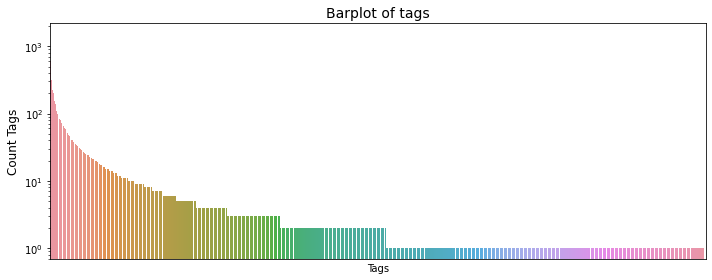

In [14]:
# df_tags.plot(kind="bar")
plt.rcParams["figure.figsize"] = (10,4)
tmp = df_tags2.sum(axis=0).sort_values(ascending=False)
sns.barplot(y=tmp.values,x=tmp.index)
plt.xlabel("Tags", fontsize=10)
# plt.xticks(rotation=90, fontsize=6) # print xticks
plt.xticks([]) # remove xticks
plt.ylabel("Count Tags", fontsize=12)
plt.yscale("log")
plt.title("Barplot of tags", fontsize=14)
plt.tight_layout()
plt.savefig(res_path+"figures/"+"barplot_tags2.jpg")
plt.show()

<a id ="section2.1"></a>
[back to menu](#menu)

## 2.A Projection des tags
Pour commencer, regardons s'il y a une structure algébrique qui se dégage des tags.


Pour rassembler les tags par sémantique, je propose de lancer une "non negative matrix factorization" (NMF), à comparer avec une Analyse en composantes principales (ACP/PCA) et un Décomposition en Valeurs Singulières tronquée (SVD)

#### NMF - Non-négatif Matrix Factorization 

In [15]:
from sklearn.decomposition import NMF
param_grid = {'n_components': np.arange(1, 20),
              'alpha': np.arange(0,1.1,0.1),
              'l1_ratio': np.arange(0,1.1,0.1)
             }
my_nmf = NMF(n_components=3, max_iter=1000, init ='nndsvdar')
my_score = frobenius_func

In [388]:
# res = pseudo_cv_reduce_dim(df_tags, my_nmf, param_grid, my_score, cv = 5)
# with open(res_path+"tags_NMF_res"+".pkl", "wb") as f :
#     pickle.dump(res, f, pickle.HIGHEST_PROTOCOL)

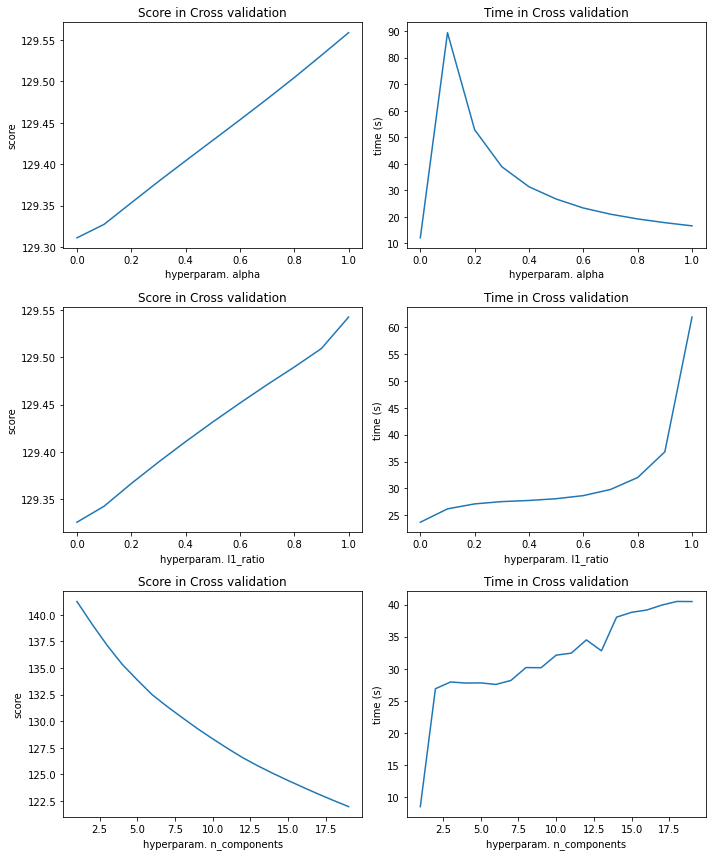

In [391]:
with open(res_path+"reduce_dim/tags_NMF_res"+".pkl", "rb") as f :
    res = pickle.load(f)
dict_log_param = {"alpha":False, "l1_ratio":False, "n_components":False}
plot_cv_res(res,dict_log_param)
plt.tight_layout()

plt.savefig(res_path+"figures/"+"tags_NMF.jpg")
res = pd.concat((pd.DataFrame(res),pd.DataFrame(res['params'])), axis =1).drop("params", axis = 1)

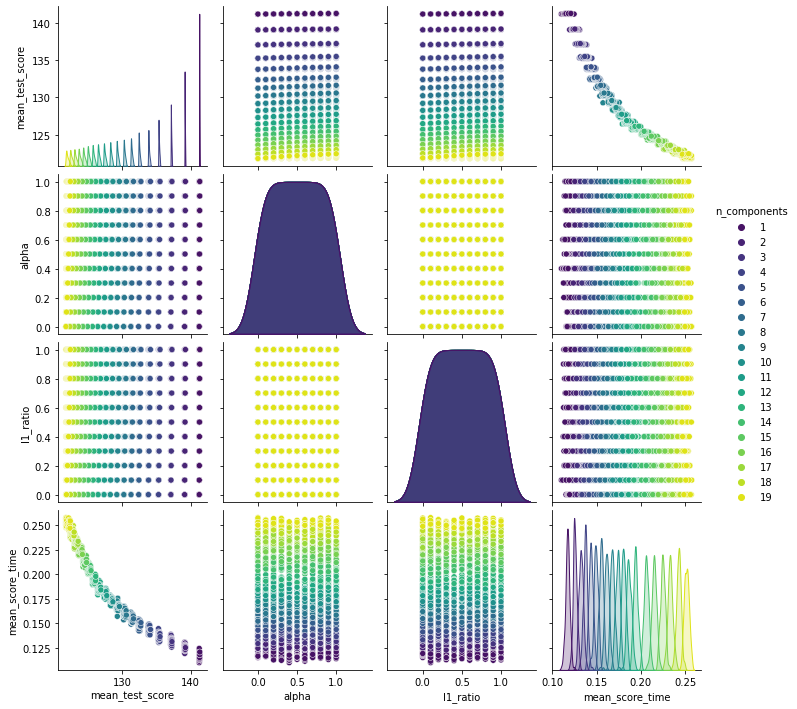

In [398]:
palette = sns.color_palette("viridis", len(res.n_components.unique()))
sns.pairplot(data = res[["mean_test_score","alpha","l1_ratio","n_components","mean_score_time"]], 
             hue = "n_components", palette=palette)
plt.show()

In [88]:
best_params = {#"n_components":12, 
               "alpha_H":0.1, "l1_ratio": 0.1,
               "init" :'nndsvdar', 
               "max_iter" : 100}

#### interprétation du NMF : 

In [85]:
tag_corpus = {idx : " ".join(df_tags2.loc[:,df_tags2.loc[idx,:] == 1].columns) for idx in df_tags2.index}

In [ ]:
countvec = CountVectorizer(ngram_range=(1,4), 
                           stop_words='english',  
                           strip_accents='unicode',
                           max_features=10000)
X = countvec.fit_transform(pd.Series(tag_corpus))
tf_feature_names = countvec.get_feature_names_out()
nmf = NMF(solver="mu", verbose = 1, **best_params)
nmf.fit(X)

Epoch 10 reached after 923.631 seconds, error: 134.177243


In [ ]:
## see notebook 2 _ test for details 
def plot_top_words(model, feature_names, n_top_words, title, n5 = 2):
    ## n5 = number of lines filled will 5 plot
    heigth_coeff = int(np.floor(n_top_words/2)+1)
    fig, axes = plt.subplots(n5, 5, figsize=(30, heigth_coeff*n5), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_[:5*n5]):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.tight_layout()
#     plt.show()

In [ ]:
plot_top_words(nmf, tf_feature_names, n_top_words=10, title="Topics in NMF model \n", n5 = 1)
plt.savefig(res_path+"figures/tags_NMF_topics")

In [ ]:
plot_top_words(nmf, tf_feature_names, n_top_words=10, title="Topics in NMF model \n", n5 = 5)
plt.savefig(res_path+"figures/tags_NMF_all_topics")

TODO Explications

#### Principal Component Analysis - ACP

Comparons les deux premiers axes avec les axes données par une ACP :

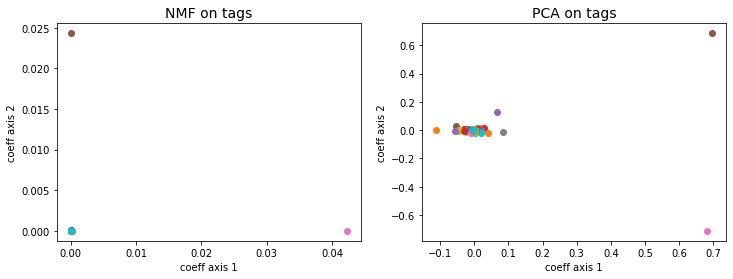

In [401]:
from sklearn.decomposition import PCA, NMF

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
coeff_nmf = plot_coeffs(NMF(**best_params, n_components=2),df_tags, "tags")
plt.legend("",frameon=False)
plt.subplot(1,2,2)
coeffs_pca = plot_coeffs(PCA(n_components=2),df_tags, "tags")
plt.legend("",frameon=False)
plt.savefig(res_path+"figures/"+"product_PCA_coeffs.jpg")
plt.show()

In [402]:
def plot_axis_coeffs(coeffs, my_meth_name = "NMF", axis_rank = [1,2] ):
    d1, d2 = axis_rank
    for colname in coeffs.columns :
        plt.scatter(x = coeffs.loc["ax_"+str(d1), colname], 
                    y = coeffs.loc["ax_"+str(d2), colname],
                    label = colname)
    plt.xlabel("coeff axis "+str(d1))
    plt.ylabel("coeff axis "+str(d2))
    plt.title(my_meth_name,fontsize=14)

In [403]:
best_params["n_components"] = 2
nmf = NMF(**best_params)
nmf.fit(df_tags)
nmf_coeffs = pd.DataFrame(nmf.components_, columns = df_tags.columns,
                      index = ["ax_"+str(k) for k in np.arange(1,nmf.n_components+1)])
## compute
pca = PCA(n_components=best_params["n_components"])
pca.fit(df_tags)
pca_coeffs = pd.DataFrame(pca.components_, columns = df_tags.columns,
                      index = ["ax_"+str(k) for k in np.arange(1,pca.n_components+1)])

/home/clairegayral/.env_python/openclassroom/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(


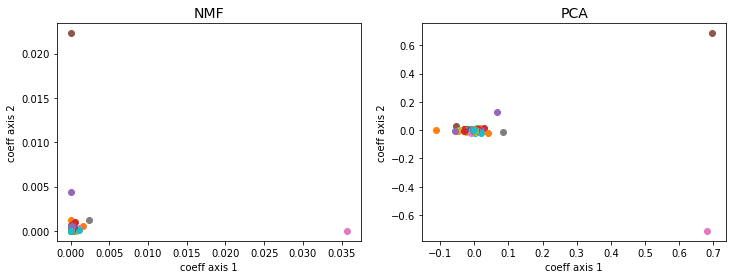

In [404]:
axis_rank = [1,2]
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_axis_coeffs(nmf_coeffs,"NMF", axis_rank)
plt.subplot(1,2,2)
plot_axis_coeffs(pca_coeffs,"PCA", axis_rank)
plt.savefig(res_path+"figures/"+"tags_NMF_PCA_coeffs12.jpg")
plt.show()

#### Singular Value Decomposition - SVD

In [405]:
from sklearn.decomposition import TruncatedSVD
pipe_svd = make_pipeline(CountVectorizer(), TruncatedSVD(n_components=300))
pipe_svd.fit(df_tags)
# feat_train_svd = pipe_svd.transform(df_tags)

svd = pipe_svd.steps[1][1]
vectorizer = pipe_svd.steps[0][1]

svd_coeffs = svd.components_
svd_coeffs = pd.DataFrame(svd.components_, columns = vectorizer.vocabulary_.keys(),
              index = ["ax_"+str(k) for k in np.arange(1,svd.n_components+1)])

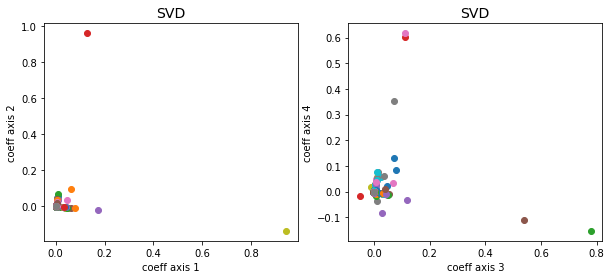

In [406]:
plt.subplot(1,2,1)
plot_axis_coeffs(svd_coeffs,"SVD", axis_rank=[1,2])
plt.subplot(1,2,2)
plot_axis_coeffs(svd_coeffs,"SVD", axis_rank=[3,4])
plt.show()

<a id ="section2.2"></a>
[back to menu](#menu)

## 2.B Regroupement en communauté des tags

La structure algébrique ne permet pas de regrouper tel quel les tags (on ne veut pas de méta-tag, cela n'a pas beaucoup de sens pour la classification à venir). Ainsi, il faut lancer un clustering. 

J'ai choisi de prendre un clustering hiérarchique, car cela permet de remonter dans les niveaux de branches pour trouver "le bon" nombre de cluster (quand ce nombre est un paramètre du kmeans). Par ailleurs, il m'a paru important de regarder la différence entre les différentes métriques proposées dans sklearn, comme les points sont en grande dimension (plus de 5000 tags) et, surtout, les seules valeurs prises sont 0 et 1 (one hot encoder), donc il y a peu de chances qu'une distance euclidienne soit performante.

#### clustering hierarchique

In [67]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=100, affinity="l1", linkage="complete")
clustering.fit(df_tags.transpose())

AgglomerativeClustering(affinity='l1', linkage='complete', n_clusters=100)

In [ ]:
# tag_corr = df_tags.corr()
# sns.clustermap(tag_corr, annot=True, linewidths=0.1, fmt='.2f', figsize=(15, 15))
# tag_corr = df_tags.corr(method="pearson", mmin_periods=ods=period=2)
# sns.clustermap(tag_corr, annot=True, linewidths=0.1, fmt='.2f', figsize=(15, 15))

# tag_corr_spearman = df_tags.corr(method="spearman")
# sns.clustermap(tag_corr_spearman, annot=True, linewidths=0.1, fmt='.2f', figsize=(15, 15))


J'ai testé avec différentes distances : 
* cosine ne sépare pas les points, 
* manhattan, aussi appelée cityblock (laissé tel quel)
* 
j'ai aussi regardé des mesure de désaccord : 
* hamming ("proportion of those vector elements between two n-vectors u and v which disagree")
* jaccard ("proportion of those elements u[i] and v[i] that disagree")
* yule https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.yule.html
* dice

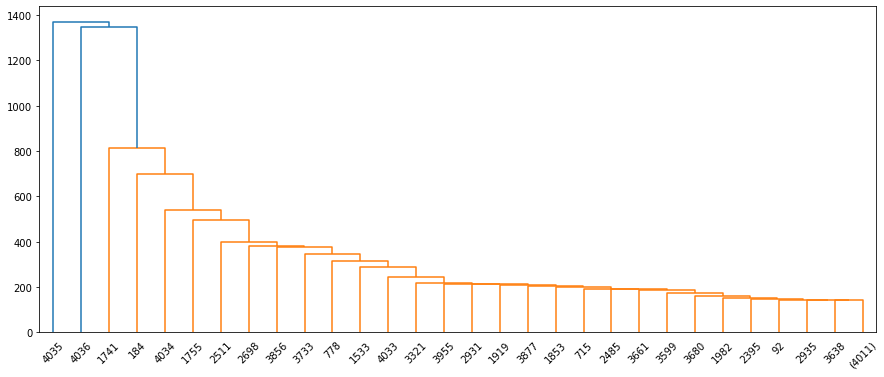

In [73]:
# Clustering hiérarchique
Z = linkage(df_tags.transpose(), method = "average", metric="cityblock")
dendrogram(Z, truncate_mode="lastp")
plt.show()

In [ ]:
Z = linkage(df_tags.transpose(), method = "average", metric="jaccard")
dendrogram(Z, p=10,truncate_mode= "level",show_leaf_counts=True)
plt.show()

In [ ]:
# plt.figure(figsize = (25,5))
plt.figure(figsize = (15,5))
dendrogram(Z, p=10,truncate_mode= "level",show_leaf_counts=True, leaf_font_size=12)
plt.xticks(rotation=90)
plt.axhline(y=0.99, c="red")
plt.savefig(res_path+"figures/hierarchical_clustering2")
plt.show()

De cette classification, je seuille à 1.99, et j'obtient les clusters suivants. 
J'en affiche quelques uns : 

In [71]:
## contenu des clusters : 
cluster_labels = fcluster(Z,t=1.99, criterion="distance")
# cluster_labels = cut_tree(Z, n_clusters=5) # ne marche pas pourquoi ?
dict_tag_clusters = {}
for cluster in np.unique(cluster_labels): 
    print("\ncluster " + str(cluster) + 
          "   // taille =" + 
          str(len(df_tags.columns[np.where(cluster_labels==cluster)[0]])))
    print(df_tags.columns[np.where(cluster_labels==cluster)[0]].values)
    dict_tag_clusters[cluster] = df_tags.columns[np.where(cluster_labels==cluster)[0]].values


cluster 1   // taille =3
['maintenance-plan' 'rebuild' 'reorganize']

cluster 2   // taille =2
['cab' 'scsf']


Ce clustering est le plus satisfaisant de ceux que j'ai eu pour le moment. Il est quand même agréable de voir que la stucture des labels permet à elle seule de faire une telle classification : le cluster 5 concerne par exemple la structure du langage (logique binaire, pascal, ...). Je vais sauvegarder cette classification dans un fichier pour l'entrainement.

In [72]:
# with open(res_path+"tags_cluster"+".pkl", "wb") as f :
#     pickle.dump(dict_tag_clusters, f, pickle.HIGHEST_PROTOCOL)

### Comment sont répartis les clusters de tags dans les posts ? 

In [38]:
with open(res_path+"tags_cluster"+".pkl", "rb") as f :
    dict_tag_clusters = pickle.load(f)
dict_tag_clusters[1]

array(['maintenance-plan', 'rebuild', 'reorganize'], dtype=object)

#### les singletons 

Il y a  64  singleton


Text(0.5, 1.0, "Nombre d'apparition des tags formant les singletons")

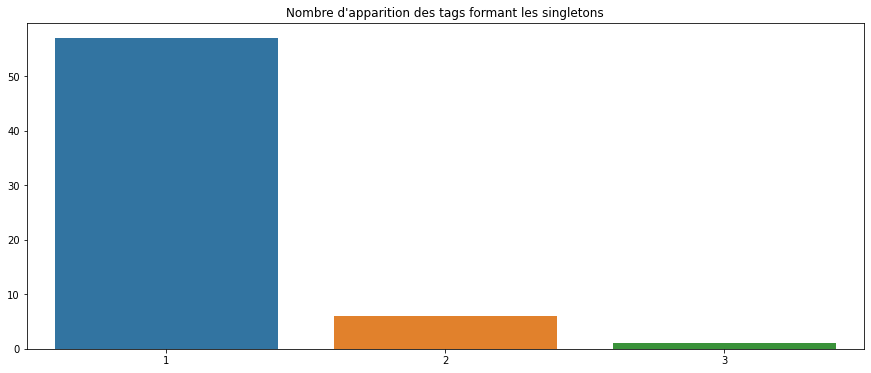

In [39]:
## etude des singletons : 
singleton_cluster = [k for k in dict_tag_clusters.keys() if len(dict_tag_clusters[k])==1]
print("Il y a ", len(singleton_cluster), " singleton")
singleton_tags = [dict_tag_clusters[k][0] for k in singleton_cluster]
tmp = df_tags.loc[:,singleton_tags].sum(axis=0)
sns.barplot(x = [int(i) for i in tmp.value_counts().index],
            y = tmp.value_counts().values)
plt.title("Nombre d'apparition des tags formant les singletons")

Ce sont des tags qui n'apparaissent qu'une ou deux fois dans l'ensemble d'apprentissage. Comparons cela à la répartition des tags de façon générale : 

In [ ]:
tmp = df_tags.sum(axis=0)
plt.figure(figsize = (20,5))
sns.barplot(x = [int(i) for i in tmp.value_counts().index],
            y = tmp.value_counts().values)
plt.xticks(rotation=90, fontsize = 9)
plt.yscale("log")
plt.title("Nombre d'apparition des tags")

In [ ]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
posts_from_singleton = df_tags[df_tags.loc[:,singleton_tags].sum(axis=1)>=1]
tmp = posts_from_singleton.sum(axis=1)
sns.barplot(x = [int(i) for i in tmp.value_counts().index],
            y = tmp.value_counts().values)
plt.title("Nombre d'apparition des tags issus des singletons")

plt.subplot(1,2,2)
tmp = df_tags.sum(axis=1)
sns.barplot(x = [int(i) for i in tmp.value_counts().index],
            y = tmp.value_counts().values)
plt.title("Nombre de tags pour les posts")

In [ ]:
tmp = df_tags.sum(axis=1)
sns.barplot(x = [int(i) for i in tmp.value_counts().index],
            y = tmp.value_counts().values)
plt.title("Nombre de tags pour les posts")
plt.savefig(res_path+"figures/tags_barplot")

Les singletons sont donc formés des posts n'ayant qu'un seul tag, qui n'apparait pas dans les autres posts. 


#### Cluster non singletons
Passons à l'étude des autres clusters :

Il y a  82  clusters non singleton


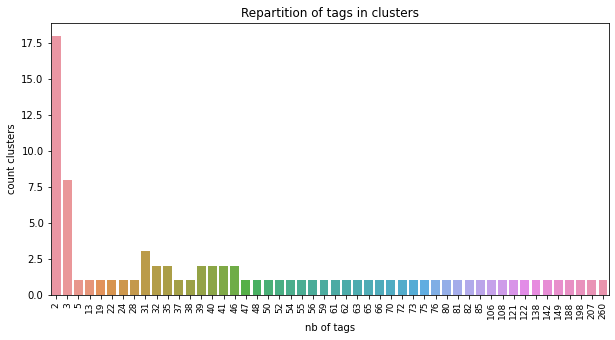

count     82.000000
mean      48.487805
std       53.139751
min        2.000000
25%        3.000000
50%       38.500000
75%       65.750000
max      260.000000
dtype: float64

In [80]:
cluster = [k for k in dict_tag_clusters.keys() if len(dict_tag_clusters[k])>1]
print("Il y a ", len(cluster), " clusters non singleton")
cluster_list_tags = [list(dict_tag_clusters[k]) for k in cluster]
distrib_cluster = {}
for k in cluster :
    distrib_cluster[k] = len(dict_tag_clusters[k])
distrib_cluster = pd.Series(distrib_cluster)
plt.figure(figsize = (10,5))
tmp = distrib_cluster.value_counts()
sns.barplot(x = [int(i) for i in tmp.index],
            y = tmp.values)
plt.xticks(rotation=90, fontsize = 9)
plt.xlabel("nb of tags")
plt.ylabel("count clusters")
plt.title("Repartition of tags in clusters")
plt.show()
distrib_cluster.describe()

Est-ce que les plus gros clusters ont un sens ?

In [81]:
big_clusters = distrib_cluster[distrib_cluster>100].index.values
data_boxplot = pd.DataFrame(columns=["index", "post_count", "cluster"])
for cluster in big_clusters :
    tags = dict_tag_clusters[cluster]
    ## extract posts where tag is present
    count_posts = [sum(df_tags[tag]==1) for tag in tags]
    count_posts = pd.Series(count_posts, index=tags, name = "post_count")
    count_posts = count_posts.reset_index()
    count_posts.at[:,"cluster"] =  cluster
    data_boxplot = pd.concat([data_boxplot,count_posts], join='inner', ignore_index=True, 
                             verify_integrity=True, sort=False, copy=True)

Text(0.5, 1.0, 'Nombre de posts où apparaissent les tags')

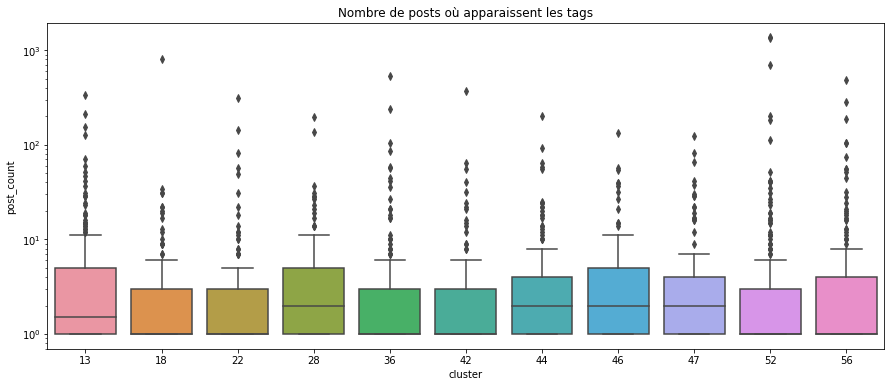

In [82]:
sns.boxplot(x="cluster", y="post_count", data=data_boxplot)
plt.yscale("log")
plt.title("Nombre de posts où apparaissent les tags")

Une grande partie des clusters sont de petite taille. Je vais regarder la répartition pour les plus gros clusters, ceux qui ont plus de 100 tags. Re

cluster 13


/home/clairegayral/.env_python/openclassroom/lib/python3.9/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


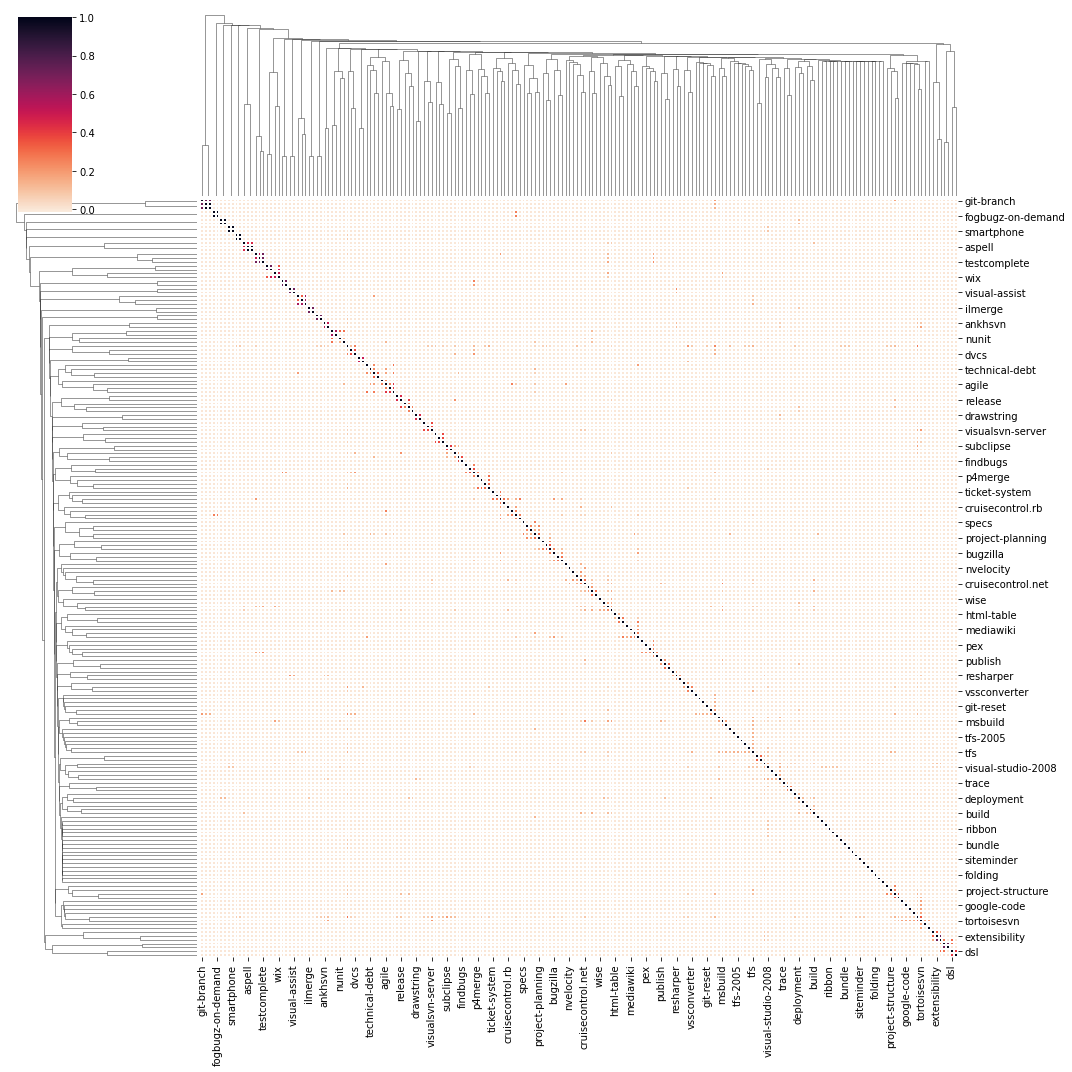

cluster 18


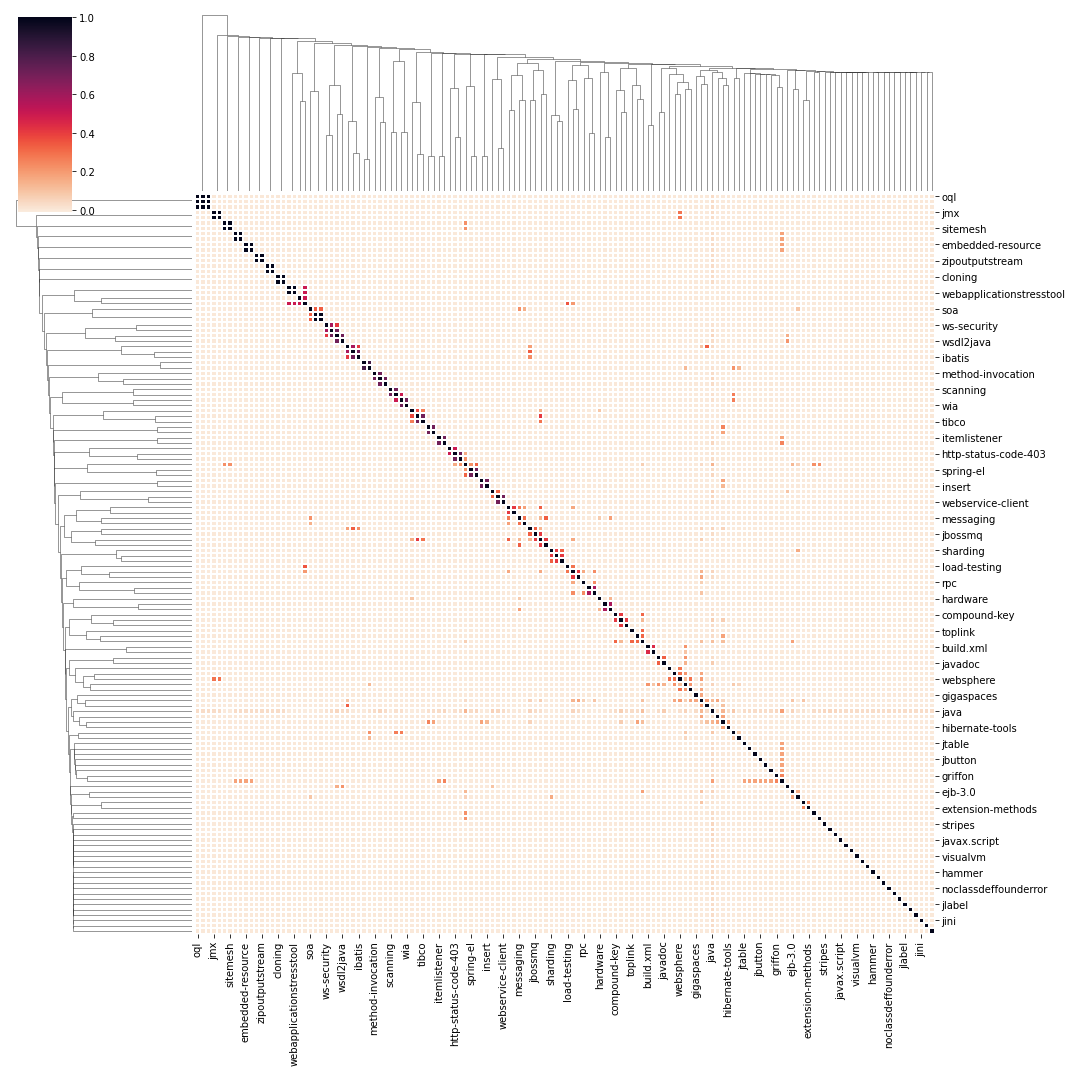

In [83]:
for cluster in big_clusters[:2] :
    print("cluster", cluster)
    tags = dict_tag_clusters[cluster]
    df_cluster = df_tags[tags]
    corr_matrix = df_cluster.corr("kendall")
    sns.clustermap(corr_matrix, cmap=sns.color_palette("rocket_r", as_cmap=True), 
                annot=False,linewidths=0.1, fmt='.2f',
                figsize=(15, 15))
    plt.show()

C'est assez étonnant que la structure soit si peu lisible dans les matrice de corrélation intra-clusters... 

<a id ="section2.3"></a>

[back to menu](#menu)

## 2.C Construction d'une variable retour y

Pour avancer dans le projet, il faut au moins que j'extrait une variable retour. Pour cela, je propose de prendre le/les tag le plus fréquent. 

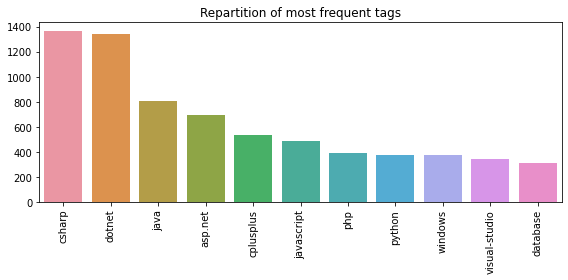

In [110]:
tmp = df_tags.sum(axis=0).sort_values(ascending=False)
thrs = 300

plt.figure(figsize=(8,4))
sns.barplot(x = tmp[tmp>thrs].index, y = tmp[tmp>thrs].values)
plt.xticks(rotation=90)
plt.title("Repartition of most frequent tags")
plt.tight_layout()
plt.savefig(res_path+"figures/"+"most_freq_tags")

In [84]:
max_tag_index = df_tags.sum(axis=0).argmax()
print("Il s'agira donc de prédire si le tag ", 
      df_tags.iloc[:, max_tag_index].name,
      "est pertinent pour le post (",
     df_tags.iloc[:, max_tag_index].sum(),
     "occurences).")
df_tags.shape

Il s'agira donc de prédire si le tag  csharp est pertinent pour le post ( 1365.0 occurences).


(11095, 4040)

### Classification uniclass :
On pourra alors voir l'apprentissage tag par tag. Mon idée initale était de réussir à regrouper les tags par sémentique : un plan langage, un plan "quoi" (affichage, question math, représentation ...), ... et faire un apprentissage multi-niveau sur chaque classe.

In [48]:
y_tag_name = df_tags.iloc[:, max_tag_index].name
y = df_tags[y_tag_name].fillna(0)
with open(res_path+"y_uniclass"+".pkl", "wb") as f :
    pickle.dump(y, f, pickle.HIGHEST_PROTOCOL)

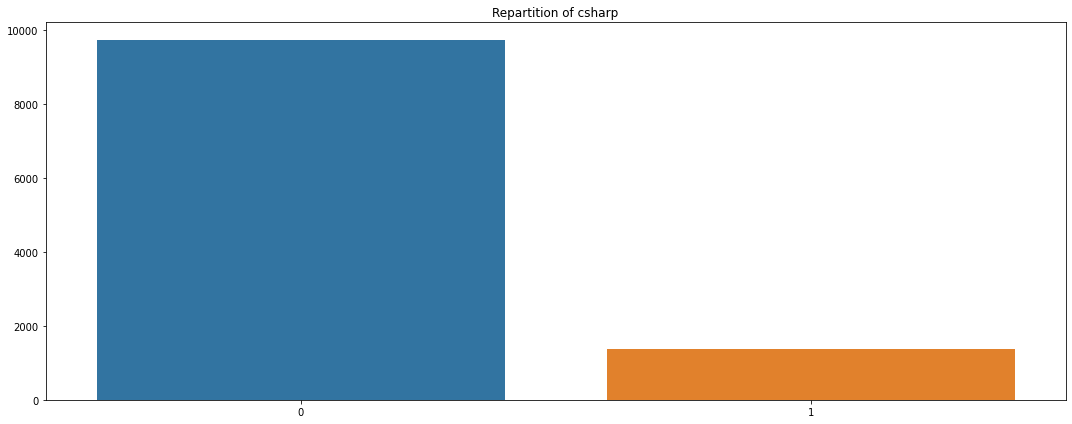

In [131]:
## Repartiton of y tags in post:
counts = pd.get_dummies(df_tags[y_tag_name])
sns.barplot(data = counts.value_counts())
plt.title("Repartition of "+y_tag_name)
plt.tight_layout()
plt.savefig(res_path+"figures/"+"y_repartition")

### Classification multi-class 
On peut essayer du multi-class avec quelques classes, quitte à généraliser par la suite. Je propose d'utiliser les regroupements fait juste au dessus, en gardant des groupes pas trop gros (pour limiter le temps de calcul) et assez représenté pour l'apprentissage. 

In [85]:
# res_path_old = '/home/clairegayral/Documents/openclassroom/res/P5_old/'
with open(res_path+"tags_cluster"+".pkl", "rb") as f :
    dict_tag_clusters = pickle.load(f)
    
clusters = list(dict_tag_clusters.values())
cluster_repartition = pd.DataFrame()
for k, cluster_col in dict_tag_clusters.items() :
    cluster_tags = df_tags.columns.intersection(cluster_col)
    if len(cluster_tags) >0 :
        n_tags_tot = float(df_tags[cluster_tags].sum().sum())
        cluster_repartition.loc[k,"count_cluster_ind"] = n_tags_tot
        cluster_repartition.loc[k,"n_clust"] = len(cluster_tags)
        cluster_repartition.loc[k,"mean_representation"] = n_tags_tot/len(cluster_tags)
tmp = cluster_repartition.sort_values("count_cluster_ind", ascending=False)
tmp.iloc[:15]

,count_cluster_ind,n_clust,mean_representation
52,4877.0,260.0,18.757692
56,2145.0,207.0,10.362319
13,1907.0,198.0,9.631313
36,1709.0,188.0,9.090426
18,1293.0,138.0,9.369565
44,1036.0,149.0,6.953020
22,994.0,121.0,8.214876
28,925.0,142.0,6.514085
42,922.0,122.0,7.557377
47,761.0,108.0,7.046296


In [65]:
dict_tag_clusters[17]

array(['.net', '.net-2.0', '.net-3.5', '.net-attributes',
       '.net-framework-version', '.nettiers', '3d-engine',
       'abstract-class', 'actualwidth', 'ada', 'add-in', 'ado', 'ado.net',
       'aero', 'ajax.net', 'al.exe', 'alias', 'alt.net', 'altova',
       'anchor', 'animation', 'animationextender', 'anonymous-methods',
       'anonymous-types', 'appbar', 'application-settings',
       'arithmetic-expressions', 'array-initialize', 'asp-classic',
       'assemblies', 'assemblyinfo', 'astoria', 'attributes',
       'auto-update', 'autoproxy', 'autosize', 'backgroundworker',
       'binaryfiles', 'bind', 'binding', 'bitmapeffect',
       'brief-bookmarks', 'btrieve', 'business-logic-layer', 'button',
       'c#', 'c#-3.0', 'cag', 'cal', 'callstack', 'camera', 'checkbox',
       'cls-compliant', 'coalesce', 'code-access-security',
       'code-analysis', 'code-reuse', 'code-translation',
       'color-management', 'combobox', 'comctl32', 'compact-framework',
       'conditional', 

In [57]:
Y_tag_dict = {
             "linux" : dict_tag_clusters[44],
             "language" : dict_tag_clusters[28],
             "microsoft" : dict_tag_clusters[42],
             "micro_service" : dict_tag_clusters[47],
             "create_website" : dict_tag_clusters[48],
             "python_website" : dict_tag_clusters[46],
             "ruby" : dict_tag_clusters[25],
             "tests" : dict_tag_clusters[12],
             "python" : dict_tag_clusters[39],
             "computer_architecture" : dict_tag_clusters[22],
             "multimedia" : dict_tag_clusters[57],
             "object_oriented" :dict_tag_clusters[21]
             }

Y = pd.DataFrame()
for k,cols in Y_tag_dict.items():
    tmp = df_tags[df_tags.columns.intersection(cols)].sum(axis=1)
    tmp[tmp>=1] = 1
    Y.loc[:,k] = tmp
    
## save results : 
with open(res_path+"y_multiclass"+".pkl", "wb") as f :
    pickle.dump(Y, f, pickle.HIGHEST_PROTOCOL)

array(['alphablending', 'bezier', 'bitmap', 'bounding-box', 'c++11', 'cg',
       'compositing', 'curve', 'dds-format', 'direct3d', 'directdraw',
       'directx', 'dirtyrectangle', 'fbo', 'framebuffer', 'glew',
       'global', 'global-state', 'glut', 'graphics', 'hotkeys',
       'inequality', 'interpolation', 'java-3d', 'lighting',
       'multisampling', 'opengl', 'psql', 'pyglet', 'scrollwheel',
       'state', 'textures', 'variables', 'vbo'], dtype=object)

In [51]:
## save results : 
with open(res_path+"y_multiclass"+".pkl", "rb") as f :
    Y = pickle.load(f)

Index(['sql', 'csharp', 'dotnet', 'java', 'asp.net', 'cplusplus', 'javascript',
       'php', 'python', 'windows', 'visual-studio', 'database', 'html',
       'clang', 'svn'],
      dtype='object')

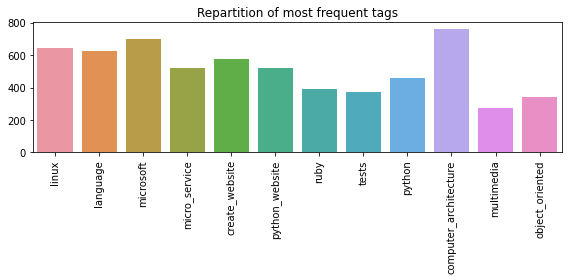

In [79]:
sorted_meta_tags = Y.sum(axis=0)

plt.figure(figsize=(8,4))
sns.barplot(x = sorted_meta_tags.index, y = sorted_meta_tags.values)
plt.xticks(rotation=90)
plt.title("Repartition of most frequent tags")
plt.tight_layout()
plt.savefig(res_path+"figures/"+"distrib_meta_tags")
most_common_tags = sorted_tags[:15].index
most_common_tags

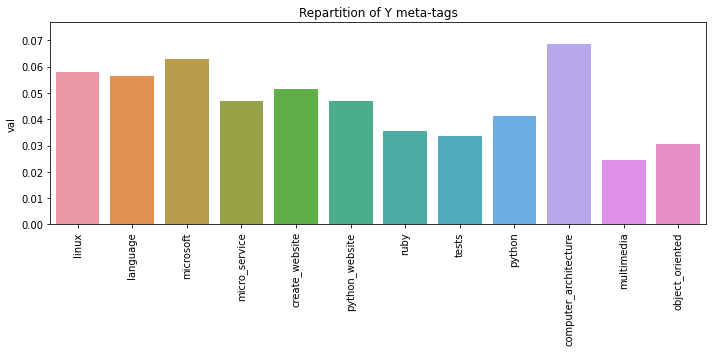

In [52]:
## Repartiton of Y tags in post:
df_tag_plot = pd.DataFrame()
for col in Y.columns:
    new = pd.DataFrame(columns=["val","tag"])
    new.loc[:,"val"] = Y.loc[:,col].copy()
    new.loc[:, "tag"] = col
    df_tag_plot = pd.concat([df_tag_plot,new],axis=0)

plt.figure(figsize=(10,5))
sns.barplot(y = "val", x= "tag", data = df_tag_plot,errwidth=0)
plt.title("Repartition of Y meta-tags")
plt.xlabel(None)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(res_path+"figures/"+"Y_distribution")

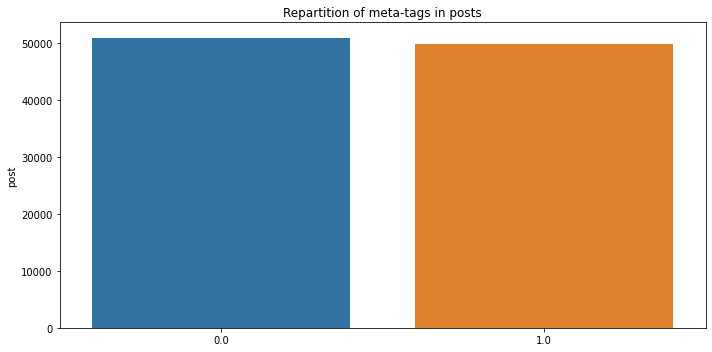

In [254]:
tmp = df_tag_plot.reset_index().rename({"index":"post"}, axis = 1)

plt.figure(figsize=(10,5))
sns.barplot(y = "post", x= "val", data = tmp,errwidth=0)
plt.title("Repartition of meta-tags in posts")
plt.xlabel(None)
plt.tight_layout()
plt.savefig(res_path+"figures/"+"Y_repartition_in_posts")

## les 20 tags les plus communs :

Index(['sql', 'csharp', 'dotnet', 'java', 'asp.net', 'cplusplus', 'javascript',
       'php', 'python', 'windows', 'visual-studio', 'database', 'html',
       'clang', 'svn'],
      dtype='object')

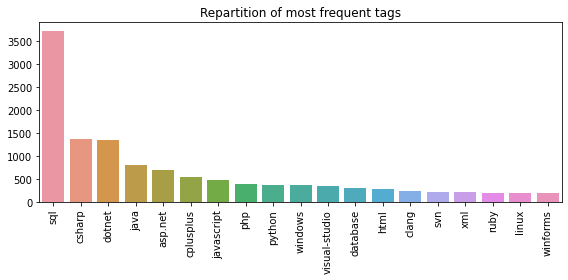

In [73]:
sorted_tags = df_tags.sum(axis=0).sort_values(ascending=False)
thrs = 200

plt.figure(figsize=(8,4))
sns.barplot(x = sorted_tags[sorted_tags>thrs].index, y = sorted_tags[sorted_tags>thrs].values)
plt.xticks(rotation=90)
plt.title("Repartition of most frequent tags")
plt.tight_layout()
plt.savefig(res_path+"figures/"+"most_freq_tags_20")

most_common_tags = sorted_tags[:15].index
most_common_tags

In [75]:
Y2 = df_tags.loc[:,most_common_tags]
Y2.head()

,sql,csharp,dotnet,java,asp.net,cplusplus,javascript,javascript,php,python,windows,visual-studio,database,html,clang,svn
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [76]:
Y2.to_csv(res_path+"Y_multiclass_most_common.csv")

<a id ="section3"></a>
<a id ="section3.1"></a>
[back to menu](#menu)

# 3. Traitements sur le texte 
## 3.A Preprocessing sur les tokens

In [344]:
with open(res_path+"tokens"+".pkl", "rb") as f :
    posts_tokens = pickle.load(f)

<a id ="section3.1.1"></a>

[back to menu](#menu)

Maintenant que mes mots sont dans un dictionnaire de liste de mot, c'est à dire de tokens (de la même forme que dans le cours d'OC), je vais pouvoir reprendre des bouts de code de le cours pour avancer plus vite. 

### 3.A.a Tokenization 

In [345]:
# tokenizer = nltk.RegexpTokenizer(r'\w+')

def freq_stats(list_tokens):
    corpora = list_tokens.copy()
    stats, freq = dict(), dict()
    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v), 'unique': len(fq.keys())} 
    return (freq, stats)

# Récupération des comptages
corpora = posts_tokens.copy()
freq, stats = freq_stats(posts_tokens)
df_tokens_stats = pd.DataFrame.from_dict(stats, orient='index')
df_tokens_stats = df_tokens_stats.sort_values('total', ascending=False)

In [346]:
save_corpora = {}
for k,v in corpora.items():
    save_corpora[k] = " ".join(v)

with open(res_path + "corpora_title_body.pkl", 'wb') as fout:
    pickle.dump(save_corpora, fout)

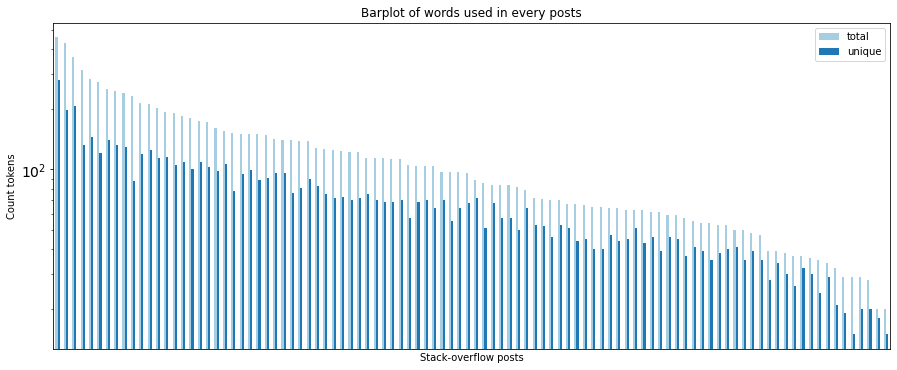

In [347]:
def plot_tokens_stats(df_tokens, figname=None):
    nb_colors = df_tokens.shape[1]
    df_tokens.plot(kind='bar', color=sns.color_palette("Paired", nb_colors),
                         title='Barplot of words used in every posts',
                         fontsize = 14,)
    plt.xticks([])
    plt.yscale("log")
    plt.xlabel("Stack-overflow posts")
    plt.ylabel("Count tokens")
    if figname is not None :
        plt.savefig(figname)
    plt.show()

# Affichage des fréquences de tokens sur un subset de post (trop lourd et rien visible sinon)
figname = res_path+"figures/"+"barplot_tokens1.jpg"
tmp = df_tokens_stats.sample(100).sort_values("total", ascending=False)
plot_tokens_stats(tmp, figname=figname)

In [348]:
print(corpora[34][:18])

['how', 'to', 'unload', 'a', 'bytearray', 'using', 'actionscript', 'how', 'do', 'i', 'forcefully', 'unload', 'a', 'bytearray', 'from', 'memory', 'using', 'actionscript']


Je trouve beaucoup trop lente la fonction "plot" de "pandas.DataFrame", et quitte à faire une fonction pour la lancer à plusieurs endroits, autant qu'elle soit plus rapide à l'exécution.

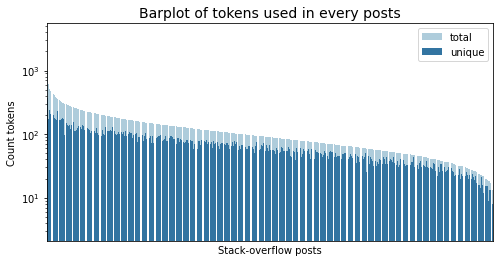

In [351]:
df_tokens = df_tokens_stats#.sample(100)
def plot_tokens_stats(df_tokens, figname=None, ylog=False):
    df_tokens = df_tokens.sort_values("total", ascending=False)
    df_tokens = df_tokens.reset_index()
    nb_colors = df_tokens.shape[1]-1
    palette=sns.color_palette("Paired", nb_colors)
    for i,var in enumerate(df_tokens.columns[1:]):
        var_color = palette[i] 
        sns.barplot(x = "index", y = var, data=df_tokens,
                    order=df_tokens["index"],
                    color=var_color, label=var, 
                    log=ylog)
    plt.legend()
    plt.title('Barplot of tokens used in every posts',fontsize = 14)
    plt.xticks([])
    if ylog :
        plt.yscale("log")
    plt.xlabel("Stack-overflow posts")
    plt.ylabel("Count tokens")
    if figname is not None :
        plt.savefig(figname)
    plt.show()
# Affichage des fréquences de tokens sur un subset de post (trop lourd et rien visible sinon)
figname = res_path+"figures/"+"barplot_tokens1.jpg"
sample_token_stat = df_tokens_stats#.sample(200)
plt.figure(figsize=(8,4))
plot_tokens_stats(sample_token_stat, figname=figname, ylog = True)

Les ordonnées sont en échelles logarithmiques car trop applaties en échelle linéaire :

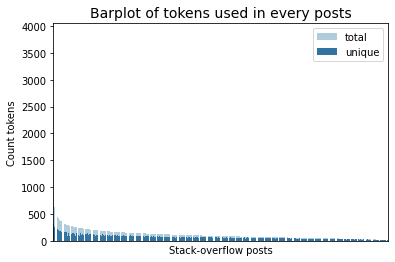

In [350]:
# Affichage des fréquences de tokens sur un subset de post (trop lourd et rien visible sinon)
figname = res_path+"figures/"+"barplot_tokens1_linear.jpg"
sample_token_stat = df_tokens_stats#.sample(200)
plt.figure(figsize=(8,4))
plot_tokens_stats(sample_token_stat, figname=figname, ylog = False)

In fine, ce qui va nous intéresser n'est pas la répartition des mots dans les posts, mais la répartition des mots pour les différents tags. Néansmoins, comme chaque post a plusieurs tags, il me parait bien plus pertinent de faire le nettoyage de ces tokens tel quel, et afficher le résultat par tags a posteriori (pas comme dans le TP, où les tokens sont affichés par artististe). 


<a id ="section3.1.2"></a>
[back to menu](#menu)

### 3.A.b Stopwords

Il ne me parait donc pas pertinent, comme dans le TP, de regarder ce que donne le même bar-plot, en retirant les mots en doublon (ici on n'a pas regroupé les tokens autre que pas post). Je propose de d'abbord faire les étapes de nettoyage et normalisation.

In [325]:
# Premièrement, on récupère la fréquence totale de chaque mot sur tout le corpus d'artistes
freq_totale = nltk.Counter()
for k, v in corpora.items():
    freq_totale += freq[k]

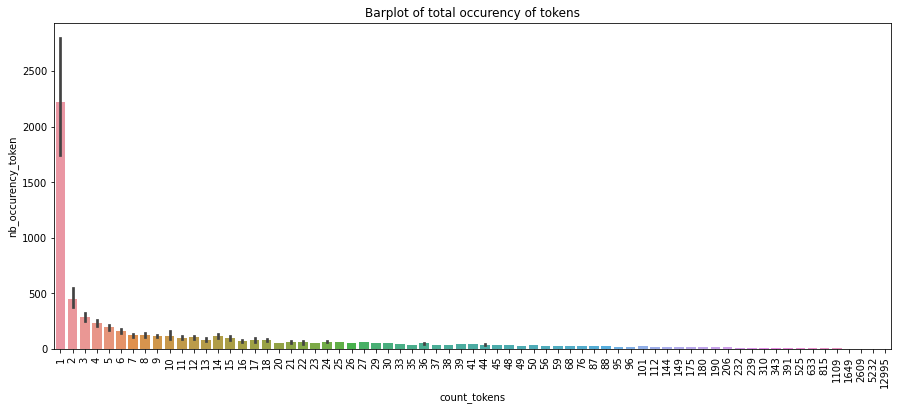

In [326]:
## Choix du seuil pour le nombre d'apparition des mots les plus frequents :
freq_count = pd.Series(freq_totale).value_counts()
freq_count = freq_count.reset_index()
freq_count = freq_count.rename(columns={"index":"nb_occurency_token", 
                                        0:"count_tokens"})
freq_count = freq_count.sort_values("count_tokens", ascending=False)

sns.barplot(data= freq_count, 
            y="nb_occurency_token", x="count_tokens")
plt.title("Barplot of total occurency of tokens")
plt.xticks(rotation=90)
plt.show()

Le graphique est trop écrasé par les grandes valeurs, je le passe à l'échelle log :

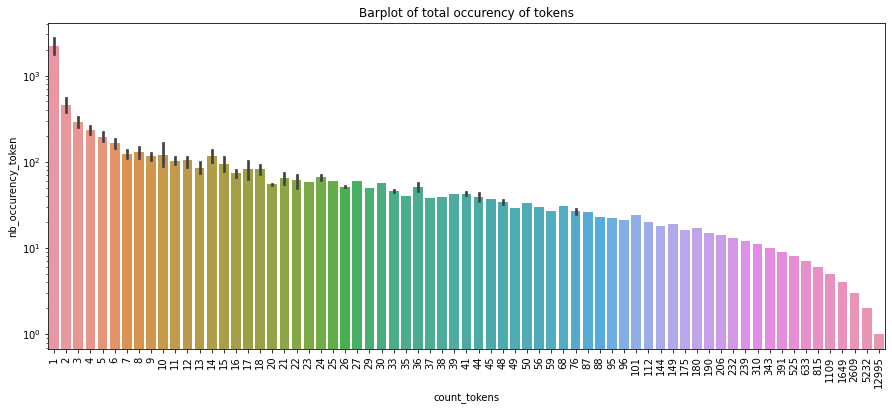

In [327]:
sns.barplot(data= freq_count, y="nb_occurency_token", x="count_tokens", log=True)
plt.title("Barplot of total occurency of tokens")
plt.xticks(rotation=90)
plt.show()

Il y l'air d'y avoir un plateau vers 200, séparons les plus fréquents des moins fréquents pour ajuster cette frontière, sur une échelle linéaire :

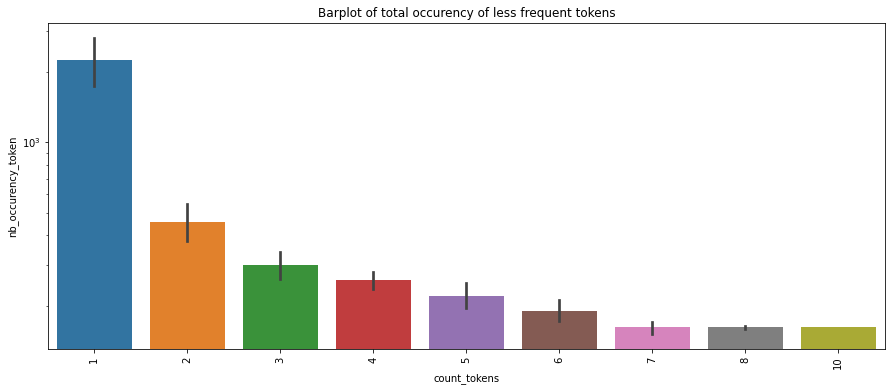

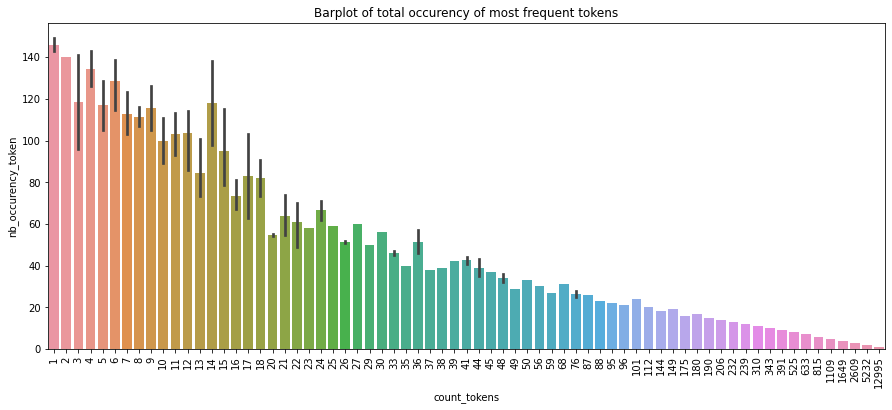

In [328]:
thrs = 150
## drop non-freq words :
not_freq_tokens = freq_count[freq_count["nb_occurency_token"] <=thrs].index
# freq_count = freq_count.drop(index=not_freq_tokens)
sns.barplot(data=freq_count.drop(index=not_freq_tokens), y="nb_occurency_token", x="count_tokens", log=True)
plt.title("Barplot of total occurency of less frequent tokens")
plt.xticks(rotation=90)
plt.show()
very_freq_tokens = freq_count[freq_count["nb_occurency_token"] >thrs].index
# freq_count = freq_count.drop(index=very_freq_tokens)
sns.barplot(data= freq_count.drop(index=very_freq_tokens), 
            y="nb_occurency_token", x="count_tokens")
plt.title("Barplot of total occurency of most frequent tokens")
plt.xticks(rotation=90)
plt.show()

In [357]:
freq_count.drop(index=not_freq_tokens)

,nb_occurency_token,count_tokens
103,163,10
107,160,8
110,164,8
123,151,7
121,171,7
...,...,...
478,2129,1
477,447,1
476,2113,1
475,495,1


Je fixe à 120 mots les plus fréquents : 

In [329]:
thrs = 120
## Deuxièmement on extrait les mots les plus fréquents :
high_freq_token = [a_tuple[0] for a_tuple in freq_totale.most_common(thrs)]

In [330]:
## Troisièmement, on ajoute ces mots fréquents aux stopwords de nltk :
# nltk.download('stopwords')
sw = set()
sw.update(high_freq_token)
sw.update(tuple(nltk.corpus.stopwords.words('english')))


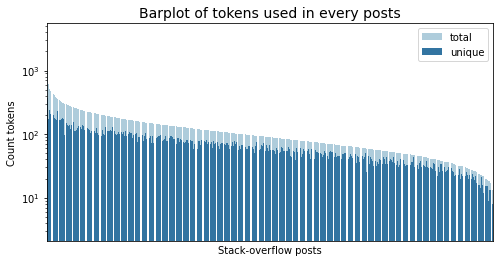

In [352]:
def freq_stats_corpora(list_tokens, stopwords=[]):
    stats, freq, corpora = dict(), dict(), dict()
    for k, v in list_tokens.items():
        corpora[k] = [w for w in list_tokens[k] if w not in list(stopwords)] 
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v), 'unique': len(fq.keys())} 
    return (freq, stats, corpora)

# Récupération des comptages
corpora = posts_tokens.copy()
freq2, stats2, corpora2 = freq_stats_corpora(posts_tokens, sw)
# df_tokens_stats = pd.DataFrame.from_dict(stats2, orient='index')
# df_tokens_stats = df_tokens_stats.sort_values('total', ascending=False)

# Affichage des fréquences de tokens sur un subset de post (trop lourd et rien visible sinon)
figname = res_path+"figures/"+"barplot_tokens2_stopwords.jpg"
# sample_token_stat = df_tokens_stats.loc[sample_token_stat.index]
# plot_tokens_stats(sample_token_stat, figname=figname, ylog = False)
df_tokens_stats2 = pd.DataFrame.from_dict(stats2, orient='index')
df_tokens_stats2 = df_tokens_stats2.sort_values('total', ascending=False)
plt.figure(figsize=(8,4))
plot_tokens_stats(df_tokens_stats2, figname=figname, ylog = True)

In [268]:
print(corpora2[34][:8])
", ".join(corpora2[34][:8])

['unload', 'bytearray', 'actionscript', 'forcefully', 'unload', 'bytearray', 'memory', 'actionscript']


'unload, bytearray, actionscript, forcefully, unload, bytearray, memory, actionscript'


<a id ="section3.1.3"></a>
[back to menu](#menu)

### 3.A.c Lemmatization 
Pour la partie de lemmatisation, comme le cours d'OC ne proposait qu'une radicalisation (car le texte était en français dans l'exemple), je me suis plutôt intéressée au [tuto de Kaggle](https://www.kaggle.com/c/word2vec-nlp-tutorial/overview/part-1-for-beginners-bag-of-words). Après avoir creusé un peu plus, comme je n'avais pas plus d'information, et surtout que le stemming a l'air assez puissant et très bien décrit, je me suis finalement lancé là-dedans 

In [332]:

stemmer = EnglishStemmer()

def freq_stats_corpora3(list_tokens,stopwords=[]):     
    stats, freq = dict(), dict()
    corpora = list_tokens.copy()
    for idx in corpora.keys() :
        tokens = corpora[idx]
        ## stop words
        tokens = [w for w in tokens if w not in list(stopwords)] 
        ## stemming
        tokens = [stemmer.stem(w) for w in tokens]
        corpora[idx] = tokens
        freq[idx] = fq = nltk.FreqDist(tokens)
        stats[idx] = {'total': len(tokens), 'unique': len(fq.keys())}
    return (freq, stats, corpora)


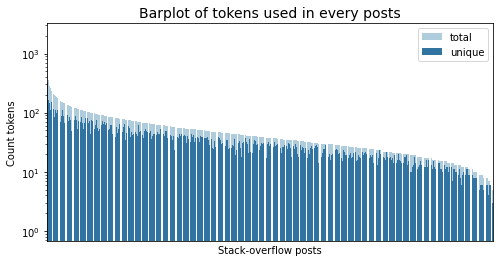

In [353]:
freq3, stats3, corpora3 = freq_stats_corpora3(posts_tokens, stopwords=sw)

df_tokens_stats = pd.DataFrame.from_dict(stats3, orient='index')
df_tokens_stats = df_tokens_stats.sort_values('total', ascending=False)

# Affichage des fréquences de tokens sur un subset de post (trop lourd et rien visible sinon)
figname = res_path+"figures/"+"barplot_tokens3_radical.jpg"
# sample_token_stat = df_tokens_stats.loc[sample_token_stat.index]
# plot_tokens_stats(sample_token_stat, figname=figname, ylog = False)
df_tokens_stats3 = pd.DataFrame.from_dict(stats3, orient='index')
df_tokens_stats3 = df_tokens_stats3.sort_values('total', ascending=False)
plt.figure(figsize=(8,4))
plot_tokens_stats(df_tokens_stats3, figname=figname, ylog = True)

In [291]:
print(corpora3[34][:8])
", ".join(corpora3[34][:8])

['unload', 'bytearray', 'actionscript', 'forc', 'unload', 'bytearray', 'memori', 'actionscript']


'unload, bytearray, actionscript, forc, unload, bytearray, memori, actionscript'

Pour la lemmatisation, j'ai trouvé [ce tuto](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/) qui propose une implémentation assez claire. Il y avait des erreurs (une utilisation dépréciée), j'ai donc fini par aller [sur la page du paquet](https://spacy.io/). J'ai comparé le traitement 

In [292]:
import spacy
nlp = spacy.load("en_core_web_sm")
# Process on a post to test the spacy syntax : 
text = " ".join(posts_tokens[4])
doc = nlp(text)
# print("Noun phrases:", [chunk.text for chunk in doc.noun_chunks])
print("Nouns:", [token.lemma_ for token in doc if token.pos_ == "NOUN"])
print("Verbs:", [token.lemma_ for token in doc if token.pos_ == "VERB"])
doc

Nouns: ['decimal', 'c', 'track', 'bar', 'form', 'opacity', 'code', 'trackbar', 'value', 'opacity', 'tran', 'application', 'error', 'type', 'tran', 'control', 'work', 'code', 'past', 'vb', 'project']
Verbs: ['convert', 'want', 'use', 'change', 'build', 'give', 'follow', 'convert', 'double', 'try', 'use', 'work']


how to convert a decimal to a double in c i want to use a track bar to change a form s opacity this is my code decimal trans trackbar value this opacity trans when i build the application it gives the following error can not implicitly convert type decimal to double i have tried using trans and double but then the control doesn t work this code worked fine in a past vb net project

In [293]:
doc = nlp(" ".join(corpora3[4]))
print("Nouns:", [token.lemma_ for token in doc if token.pos_ == "NOUN"])
print("Verbs:", [token.lemma_ for token in doc if token.pos_ == "VERB"])
doc

Nouns: ['decim', 'doubl', 'track', 'bar', 'decim', 'trackbar', 'opac', 'build', 'give', 'convert', 'decim', 'doubl', 'doubl', 'control', 'work', 'vb']
Verbs: ['convert', 'form', 'tran', 'tran', 'tran']


convert decim doubl track bar chang form opac decim tran trackbar opac tran build give follow implicit convert decim doubl tri tran doubl control work fine past vb

In [294]:
def lemmatization(list_tokens, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    doc =  nlp(" ".join(list_tokens)) 
    out = []
    for token in doc : 
        if token.pos_ in allowed_postags: 
            if token.lemma_ not in ['-PRON-']:
                out.append(token.lemma_)
    return out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
import spacy
tokens = posts_tokens[4]
# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(tokens, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized)

['how', 'convert', 'decimal', 'double', 'c', 'want', 'use', 'track', 'bar', 'change', 'form', 'opacity', 'code', 'decimal', 'trackbar', 'value', 'opacity', 'tran', 'when', 'build', 'application', 'give', 'follow', 'error', 'implicitly', 'convert', 'type', 'decimal', 'double', 'try', 'use', 'tran', 'double', 'then', 'control', 'work', 'code', 'work', 'fine', 'past', 'vb', 'net', 'project']


Bon, du coup il a l'air préférable de faire la lemmatisation avant de faire les autres prétraitements. 

In [295]:
def from_post_to_tokens(list_tokens, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'], stopwords=[]):        
    stats, freq = dict(), dict()
    corpora = list_tokens.copy()
    for idx in corpora.keys() :
        tokens = corpora[idx]
        ## stop words
        tokens = [w for w in tokens if w not in list(stopwords)] 
        ## stemming
        tokens = [stemmer.stem(w) for w in tokens]
        ## lemmatization 
        tokens = lemmatization(tokens, allowed_postags=allowed_postags)
        ## save results
        corpora[idx] = tokens
        freq[idx] = fq = nltk.FreqDist(tokens)
        stats[idx] = {'total': len(tokens), 'unique': len(fq.keys())}
    return (freq, stats, corpora)

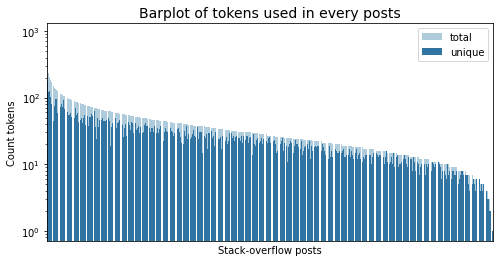

In [354]:
freq4, stats4, corpora4 = from_post_to_tokens(posts_tokens, stopwords=sw)

df_tokens_stats = pd.DataFrame.from_dict(stats4, orient='index')
df_tokens_stats = df_tokens_stats.sort_values('total', ascending=False)

# Affichage des fréquences de tokens sur un subset de post (trop lourd et rien visible sinon)
figname = res_path+"figures/"+"barplot_tokens4_radical.jpg"
# sample_token_stat = df_tokens_stats.loc[sample_token_stat.index]
# plot_tokens_stats(sample_token_stat, figname=figname, ylog = False)
df_tokens_stats4 = pd.DataFrame.from_dict(stats4, orient='index')
df_tokens_stats4 = df_tokens_stats4.sort_values('total', ascending=False)
plt.figure(figsize=(8,4))
plot_tokens_stats(df_tokens_stats4, figname=figname, ylog = True)

In [355]:
print(corpora4[34][:8])
", ".join(corpora4[34])

['actionscript', 'follow', 'first', 'non', 'work', 'second', 'non', 'work']


'actionscript, follow, first, non, work, second, non, work, solut, var, length, null'

Je propose de garder ces premiers traitements pour la suite. je les enregistre pour partir directement d'ici : 

In [369]:
## save results
data_lemmatized = []
for list_text in corpora4.values():
    text  = " ".join(list_text)
    data_lemmatized.append(text)

vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

## transform into bag of words : 
data_vectorized = vectorizer.fit_transform(data_lemmatized)

## save results : 
import pickle

filename = res_path + "tokenization.pkl"
with open(filename, 'wb') as fout:
    pickle.dump((vectorizer, data_vectorized), fout)

In [370]:
import pickle

filename = res_path + "tokenization.pkl"
with open(filename, 'rb') as f:
    vectorizer, data_vectorized = pickle.load(f)


<AxesSubplot:ylabel='Count'>

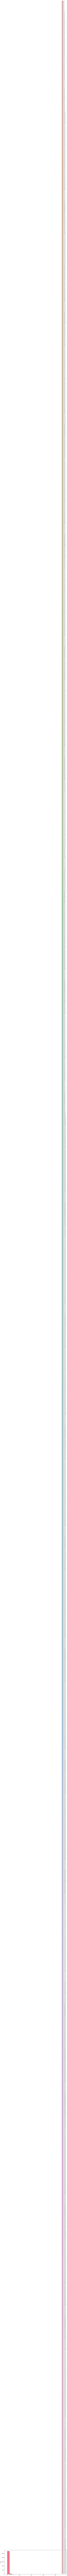

In [375]:
tmp = pd.DataFrame(data_vectorized.todense())
sns.histplot(tmp)

Comme dans le tuto, je regarde la sparcité de ma matrice :

In [300]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.9021571109350445 %


In [301]:
data_dense

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 2, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]])

<a id ="section3.2"></a>
<a id ="section3.2.1"></a>
[back to menu](#menu)

## 3.B Représentation des mots :

### 3.B.a Bag of Words 

TODO explain

<a id ="section3.2.2"></a>
[back to menu](#menu)

### 3.B.b tf-idf

Tf-idf est [une représentation vectorielle d'un ensemble de mots](https://fr.wikipedia.org/wiki/TF-IDF), où chaque mot est représenté par le nombre de fois où il apparait dans le corpus : si le mort apparait peu de fois, il doit être particulièrement important. 

In [ ]:
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed
def my_tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems
tfidf = TfidfVectorizer(tokenizer=my_tokenize, stop_words=[])
data_tfidf = tfidf.fit_transform(data_lemmatized)

In [ ]:
print(data_tfidf[0])

<a id ="section3.2.3"></a>
[back to menu](#menu)

### 3.B.c Word to vect

Je me suis ensuite muni d'outils pré-entrainés pour réduire la dimension et la sparcité de ma matrice de design. Pour cela, j'ai utilisé la bibliothèque "gensim", et [le tuto suivant](https://rare-technologies.com/word2vec-tutorial/). 

D'autres bibliothèques de nlp (notamment spacy) proposent une implémentation de ces process.

In [ ]:
sentences = data_lemmatized
model = models.Word2Vec(sentences)

In [ ]:
## attention : copie pour debug
def lemmatization(list_tokens, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    doc =  nlp(" ".join(list_tokens)) 
    out = []
    for token in doc : 
        if token.pos_ in allowed_postags: 
            if token.lemma_ not in ['-PRON-']:
                out.append(token.lemma_)
    return out

def from_post_to_tokens_gensim(dict_posts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'], stopwords=[]):        
    corpora = {}#dict_posts.copy()
    for idx in dict_posts.keys() :
        doc = dict_posts[idx]
        ## preprocess from gensim : 
        tokens = tokenize(doc, lowercase=True, deacc=True, 
                           encoding='utf8', errors='strict')
        ## stop words
        tokens = [w for w in tokens if w not in list(stopwords)] 
        ## stemming
#         tokens = [stemmer.stem(w) for w in tokens]
        ## lemmatization 
        tokens = " ".join(lemmatization(tokens, allowed_postags=allowed_postags))
        ## save results
        corpora[idx] = tokens
    return(corpora)

In [71]:
corpora_tokens = from_post_to_tokens_gensim(posts, stopwords=sw)

# with open(res_path+"posts_cleanned_corpora_tokens"+".pkl", "wb") as f :
#     pickle.dump(corpora_tokens, f, pickle.HIGHEST_PROTOCOL)

with open(res_path+"posts_cleanned_corpora_tokens"+".pkl", "rb") as f :
    corpora = pickle.load(f)
    
sentences = corpora_tokens.values()

<a id ="section3.2.4"></a>
[back to menu](#menu)

### 3.B.d Nuages de mots

https://datascientest.com/wordcloud-python

In [273]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

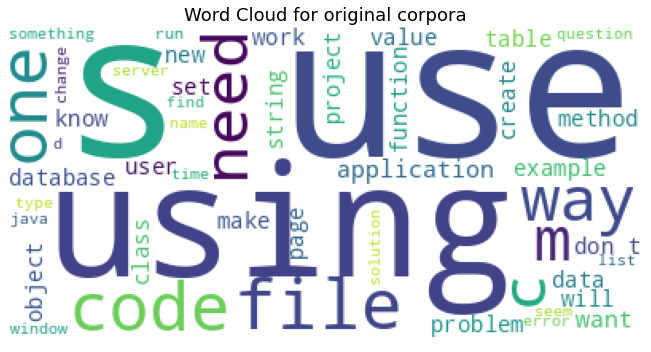

In [313]:
## on not preprocessed data :
text = " ".join([" ".join(t) for t in corpora.values()])
wordcloud = WordCloud(background_color = 'white', max_words = 50).generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Word Cloud for original corpora", fontsize = 18)
plt.tight_layout()
plt.savefig(res_path + "figures/word_cloud_corpora")
plt.show()

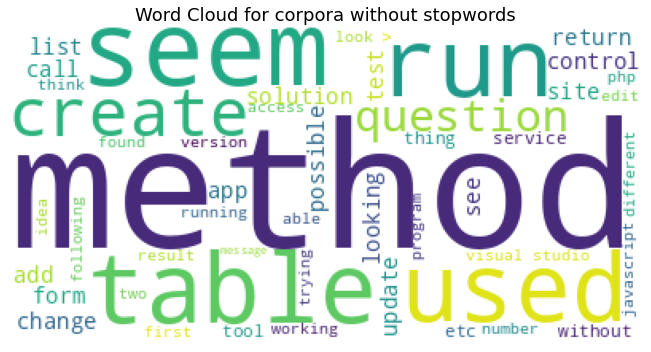

In [315]:
## on not preprocessed data :
text = " ".join([" ".join(t) for t in corpora2.values()])
wordcloud = WordCloud(background_color = 'white', max_words = 50).generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Word Cloud for corpora without stopwords", fontsize = 18)
plt.tight_layout()
plt.savefig(res_path + "figures/word_cloud_corpora2")
plt.show()

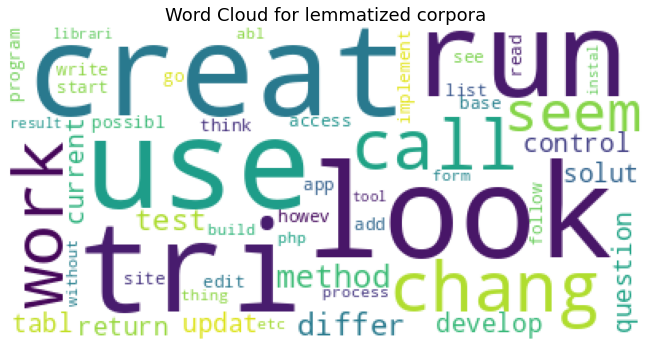

In [316]:
## on not preprocessed data :
text = " ".join([" ".join(t) for t in corpora3.values()])
wordcloud = WordCloud(background_color = 'white', max_words = 50).generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Word Cloud for lemmatized corpora", fontsize = 18)
plt.tight_layout()
plt.savefig(res_path + "figures/word_cloud_corpora3")
plt.show()

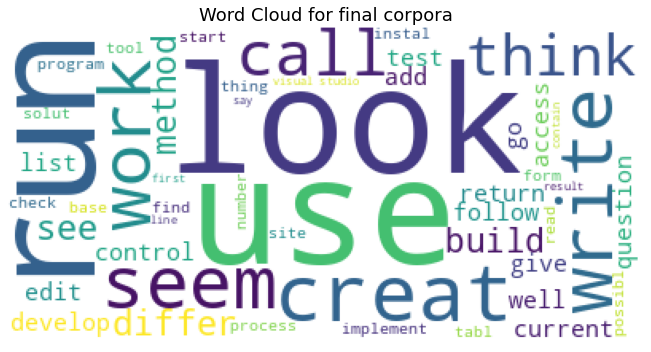

In [318]:
## on not preprocessed data :
text = " ".join([" ".join(t) for t in corpora4.values()])
wordcloud = WordCloud(background_color = 'white', max_words = 50).generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Word Cloud for final corpora", fontsize = 18)
plt.tight_layout()
plt.savefig(res_path + "figures/word_cloud_corpora4")
plt.show()

<a id ="section3.3"></a>
[back to menu](#menu)

# 3.C Réduction de dimension


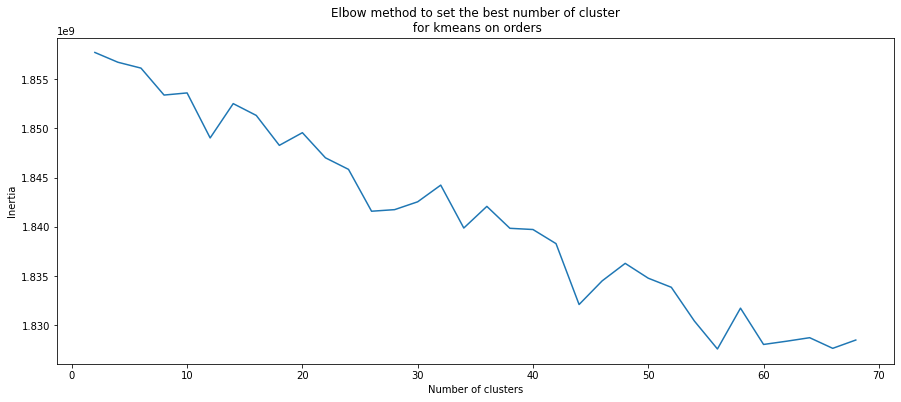

In [50]:
## Standardization : 
my_std = StandardScaler(with_mean=False)#mean false because sparce
X = data_tfidf
my_std.fit(X)
X_std = my_std.transform(X)

list_n_clusters = np.arange(2,70,2)
# Elbow-Method/SSD 
ssd = []
for num_clusters in list_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=100)
    kmeans.fit(X_std)
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(list_n_clusters,ssd)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow method to set the best number of cluster\n for kmeans on orders")
plt.savefig(res_path+"figures/"+"tfidf_kmeans_inertia.jpg")
plt.show()

<a id ="section2"></a>
[back to menu](#menu)

# 2. Répartition des tags 